# Prereq

In [ ]:
!pip install tensortrade ray[tune,rllib] symfit

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

num_gpus = len(get_available_gpus())
print(num_gpus)

1


# Setup

### Imports

In [ ]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)
from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent

import pandas as pd

import tensortrade.env.default as default

from ray import tune
from ray.tune.registry import register_env



### Util

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
def get_available_cpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'CPU']
num_gpus = len(get_available_gpus())
num_cpus = len(get_available_cpus())

### Data

In [ ]:
# Fetch Data
cdd = CryptoDataDownload()
data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
def CPLogRSIMacdFeed():
    
    def rsi(price: Stream[float], period: float) -> Stream[float]:
        r = price.diff()
        upside = r.clamp_min(0).abs()
        downside = r.clamp_max(0).abs()
        rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
        return 100*(1 - (1 + rs) ** -1)


    def macd(price: Stream[float], fast: float, slow: float, signal: float) -> Stream[float]:
        fm = price.ewm(span=fast, adjust=False).mean()
        sm = price.ewm(span=slow, adjust=False).mean()
        md = fm - sm
        signal = md - md.ewm(span=signal, adjust=False).mean()
        return signal


    features = []
    for c in data.columns[1:]:
        s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
        features += [s]

    cp = Stream.select(features, lambda s: s.name == "close")

    features = [
        # Remove auto correlation
        cp.log().diff().rename("lr"),
        rsi(cp, period=20).rename("rsi"),
        macd(cp, fast=10, slow=50, signal=5).rename("macd")
    ]

    feed = DataFeed(features)
    feed.compile()


    return feed

### Portfolio

In [ ]:
from tensortrade.oms.instruments import USD, BTC, ETH
portfolios = []
def getPortfolio(exchange, usd=50000, btc=1):
    portfolio = Portfolio(USD, [
        Wallet(exchange, usd * USD),
        Wallet(exchange, btc * BTC)
    ])

    portfolios.append(portfolio)

    return portfolio


# Rendering

In [ ]:
# Position Change Chart
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        d = env.action_scheme.portfolio.performance

        # lists = sorted(d.items()) # sorted by key, return+ a list of tuples
        keys = d[0].keys()
        x = range(len(d))
        c = {}

        for i in range(len(d)):
            for key in keys:
                if key != 'net_worth' and key != 'base_symbol':
                    if not key in c:
                        c[key] = []
                    c[key].append(d[i][key])

        for key in keys:
            if key != 'net_worth' and key != 'base_symbol':
                axs[1].plot(x, c[key], label=key)
        
        axs[1].set_title("Net Worth")

        plt.show()

# Define Model


### Reward Schemes

In [ ]:
# Reward Schemes
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.env.generic import RewardScheme
# from tensortrade.rewards import RewardStrategy
# from tensortrade.trades import Trade

class PBR(TensorTradeRewardScheme):
    """A reward scheme for position-based returns.

    * Let :math:`p_t` denote the price at time t.
    * Let :math:`x_t` denote the position at time t.
    * Let :math:`R_t` denote the reward at time t.

    Then the reward is defined as,
    :math:`R_{t} = (p_{t} - p_{t-1}) \cdot x_{t}`.

    Parameters
    ----------
    price : `Stream`
        The price stream to use for computing rewards.
    """

    registered_name = "pbr"

    def __init__(self, price: 'Stream') -> None:
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (position * r).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int) -> None:
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio') -> float:
        return self.feed.next()["reward"]

    def reset(self) -> None:
        """Resets the `position` and `feed` of the reward scheme."""
        self.position = -1
        self.feed.reset()


# class DirectProfitStrategy(RewardScheme):
#     '''This reward = how much money that the strategy earns'''
#     def reset(self):
#         """Necessary to reset the open amount and the last price"""
#         self._open_amount= 0
#         self._last_price = 0

#     def get_reward(self, current_step: int, trade: Trade) -> float:
#         last_price = self._last_price
#         price = trade.price
#         last_amount = self._open_amount

#         #reset values
#         if trade.is_hold:
#             pass
#         elif trade.is_buy:
#             self._open_amount += trade.amount
#         elif trade.is_sell:
#             self._open_amount -= trade.amount

#         last_price = self._last_price

#         self._last_price = trade.price        
        
#         if trade.is_hold:
#             return last_amount * (price - last_price)
#         else:
#             return last_amount * (price - last_price) - trade.amount * trade.price * 0.0003

### Action Scheme

In [ ]:
# BuySellHold
class BuySellHold(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0


# Trading Environment

In [ ]:
from tensortrade.env.default.rewards import SimpleProfit
from tensortrade.env.default.actions import BSH

def create_env(config):
    p = Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")

    # Define exchange
    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )

    portfolio = getPortfolio(bitfinex, 50000, 1)

    feed = CPLogRSIMacdFeed()

    for i in range(5):
        print(feed.next())

    reward_scheme = PBR(price=p)

    action_scheme = BuySellHold(
        cash=portfolio.wallets[0],
        asset=portfolio.wallets[1]
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(list(data["date"])).rename("date"),
        Stream.source(list(data["open"]), dtype="float").rename("open"),
        Stream.source(list(data["high"]), dtype="float").rename("high"),
        Stream.source(list(data["low"]), dtype="float").rename("low"),
        Stream.source(list(data["close"]), dtype="float").rename("close"),
        Stream.source(list(data["volume"]), dtype="float").rename("volume")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=BSH(
            cash=portfolio.wallets[0],
            asset=portfolio.wallets[1]
        ),
        reward_scheme=SimpleProfit(),
        renderer_feed=renderer_feed,
        # renderer=default.renderers.PlotlyTradingChart(),
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

register_env("TradingEnv", create_env)


# Training

In [ ]:
analysis = tune.run(
    "PPO",
    stop={
      "training_iteration": 100
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True,
    mode="max"
)


Trial name,status,loc
PPO_TradingEnv_ac7e4_00000,PENDING,


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=1909) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1909) Instructions for updating:
(pid=1909) non-resource variables are not supported in the long term
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "updat

(pid=1937) {'lr': nan, 'rsi': nan, 'macd': 0.0}
(pid=1937) {'lr': 0.00045761355334761333, 'rsi': 100.0, 'macd': 0.3802733214494462}
(pid=1937) {'lr': -0.0022099203461092287, 'rsi': 16.45021645021696, 'macd': -1.2850831900864756}
(pid=1937) {'lr': -0.001789832853125617, 'rsi': 9.61512851245181, 'macd': -3.5410157838872425}
(pid=1937) {'lr': 0.00872379407148216, 'rsi': 71.2075575333076, 'macd': 2.810321575123835}


(pid=1937) 2021-04-25 11:45:13,704	INFO simple_list_collector.py:685 -- Trajectory fragment after postprocess_trajectory():
(pid=1937) 
(pid=1937) { 'agent0': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-0.011, max=0.016, mean=0.001),
(pid=1937)               'action_logp': np.ndarray((200,), dtype=float32, min=-0.702, max=-0.683, mean=-0.694),
(pid=1937)               'action_prob': np.ndarray((200,), dtype=float32, min=0.496, max=0.505, mean=0.5),
(pid=1937)               'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.5),
(pid=1937)               'advantages': np.ndarray((200,), dtype=float32, min=-1.013, max=1.007, mean=-0.384),
(pid=1937)               'agent_index': np.ndarray((200,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1937)               'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
(pid=1937)               'eps_id': np.ndarray((200,), dtype=int64, min=1097499381.0, max=1097499381.0, mean=1097499381.0),
(

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-04-25_11-45-30
  done: false
  episode_len_mean: 275.92857142857144
  episode_media: {}
  episode_reward_max: -0.5074792722103028
  episode_reward_mean: -0.5116379591160387
  episode_reward_min: -0.526563729993532
  episodes_this_iter: 14
  episodes_total: 14
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 8.0e-06
          entropy: 0.6804733481258154
          entropy_coeff: 0.01
          kl: 0.012773005350027233
          policy_loss: -0.03113506973022595
          total_loss: 0.32169100595638156
          vf_explained_var: 0.027326490730047226
          vf_loss: 0.7141524199396372
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 17

(pid=1909) 2021-04-25 11:45:30,787	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4015, mean_mean=13.55875526756683, mean_std=10.535694717648523), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,1,17.5687,4000,-0.511638,-0.507479,-0.526564,275.929


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-04-25_11-45-48
  done: false
  episode_len_mean: 285.5
  episode_media: {}
  episode_reward_max: -0.5067132428447974
  episode_reward_mean: -0.5113396681235785
  episode_reward_min: -0.526563729993532
  episodes_this_iter: 14
  episodes_total: 28
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 0.0007000000000000001
          entropy: 0.6143910735845566
          entropy_coeff: 0.01
          kl: 0.05595968244597316
          policy_loss: -0.15788354276446626
          total_loss: 0.04525322307017632
          vf_explained_var: 0.3696795701980591
          vf_loss: 0.39617747347801924
    num_agent_steps_sampled: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 172

(pid=1909) 2021-04-25 11:45:48,231	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=8029, mean_mean=13.656625636267684, mean_std=10.448150139803257), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,2,34.9756,8000,-0.51134,-0.506713,-0.526564,285.5


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-04-25_11-46-06
  done: false
  episode_len_mean: 329.3333333333333
  episode_media: {}
  episode_reward_max: -0.505291791327272
  episode_reward_mean: -0.5105754281342777
  episode_reward_min: -0.526563729993532
  episodes_this_iter: 8
  episodes_total: 36
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.30000000000000004
          cur_lr: 0.00030000000000000003
          entropy: 0.5044625252485275
          entropy_coeff: 0.01
          kl: 0.05649646371603012
          policy_loss: -0.12002527405275032
          total_loss: 0.09052051565959118
          vf_explained_var: 0.4260028600692749
          vf_loss: 0.3972829384729266
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_s

(pid=1909) 2021-04-25 11:46:06,067	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=12037, mean_mean=14.169791364776493, mean_std=10.318636288221066), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,3,52.7755,12000,-0.510575,-0.505292,-0.526564,329.333


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)
(pid=1937) 2021-04-25 11:46:13,705	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 54237.556961928,
(pid=1937)                                             'step': 163},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.531, max=1.414, mean=-0.038),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': -0.009937932766476587,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-04-25_11-46-24
  done: false
  episode_len_mean: 380.07142857142856
  episode_media: {}
  episode_reward_max: -0.5045670160033054
  episode_reward_mean: -0.5112640400632257
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 6
  episodes_total: 42
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.45000000000000007
          cur_lr: 9.800000000000001e-05
          entropy: 0.44482414331287146
          entropy_coeff: 0.01
          kl: 0.029723985644523054
          policy_loss: -0.09434056770987809
          total_loss: 0.08952181438507978
          vf_explained_var: 0.5152446031570435
          vf_loss: 0.3498696628957987
    num_agent_steps_sampled: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iteratio

(pid=1909) 2021-04-25 11:46:24,538	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=16043, mean_mean=14.407192040287589, mean_std=10.17430156706191), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,4,71.2092,16000,-0.511264,-0.504567,-0.535692,380.071


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-04-25_11-46-43
  done: false
  episode_len_mean: 417.7391304347826
  episode_media: {}
  episode_reward_max: -0.5035977114295217
  episode_reward_mean: -0.5107730862644606
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 4
  episodes_total: 46
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 9.400000000000001e-05
          entropy: 0.4064576104283333
          entropy_coeff: 0.01
          kl: 0.019368047709576786
          policy_loss: -0.0835642981401179
          total_loss: 0.08152775705093518
          vf_explained_var: 0.5601264238357544
          vf_loss: 0.3121664081700146
    num_agent_steps_sampled: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore:

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,5,89.7339,20000,-0.510773,-0.503598,-0.535692,417.739


(pid=1909) 2021-04-25 11:46:43,101	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=20047, mean_mean=14.571464911351631, mean_std=10.052935665662485), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-04-25_11-47-02
  done: false
  episode_len_mean: 470.27450980392155
  episode_media: {}
  episode_reward_max: -0.5018533004236672
  episode_reward_mean: -0.5099953761724857
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 5
  episodes_total: 51
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 9.0e-05
          entropy: 0.3756561949849129
          entropy_coeff: 0.01
          kl: 0.015828532603336498
          policy_loss: -0.0707627217634581
          total_loss: 0.07667460915399715
          vf_explained_var: 0.6105383634567261
          vf_loss: 0.2810192690230906
    num_agent_steps_sampled: 24000
    num_steps_sampled: 24000
    num_steps_trained: 24000
  iterations_since_restore: 6
  node_ip:

(pid=1909) 2021-04-25 11:47:02,094	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=24052, mean_mean=14.687437765643883, mean_std=10.001834760952605), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,6,108.69,24000,-0.509995,-0.501853,-0.535692,470.275


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-04-25_11-47-21
  done: false
  episode_len_mean: 502.5740740740741
  episode_media: {}
  episode_reward_max: -0.5018533004236672
  episode_reward_mean: -0.509690464068943
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 3
  episodes_total: 54
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 8.6e-05
          entropy: 0.34511471912264824
          entropy_coeff: 0.01
          kl: 0.01562951973755844
          policy_loss: -0.06787052136496641
          total_loss: 0.05889565183315426
          vf_explained_var: 0.6589968204498291
          vf_loss: 0.23933478887192905
    num_agent_steps_sampled: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
  iterations_since_restore: 7
  node_ip:

(pid=1909) 2021-04-25 11:47:21,284	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=28055, mean_mean=14.787342568412287, mean_std=9.94105045426571), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,7,127.841,28000,-0.50969,-0.501853,-0.535692,502.574


(pid=1937) 2021-04-25 11:47:21,319	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 40807.832287373996,
(pid=1937)                                             'step': 861},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.491, max=1.704, mean=0.234),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': 0.0005451076587625892,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 11:47:21,322	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=1937)         

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-04-25_11-47-40
  done: false
  episode_len_mean: 543.8965517241379
  episode_media: {}
  episode_reward_max: -0.49939614227815377
  episode_reward_mean: -0.5091882757317687
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 4
  episodes_total: 58
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 8.2e-05
          entropy: 0.31171534955501556
          entropy_coeff: 0.01
          kl: 0.01334575074724853
          policy_loss: -0.05767484303214587
          total_loss: 0.07440634843078442
          vf_explained_var: 0.6349403262138367
          vf_loss: 0.2523799273185432
    num_agent_steps_sampled: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
  iterations_since_restore: 8
  node_ip

(pid=1909) 2021-04-25 11:47:40,753	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=32059, mean_mean=14.867937792010459, mean_std=9.920764515067043), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,8,147.274,32000,-0.509188,-0.499396,-0.535692,543.897


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-04-25_11-47-59
  done: false
  episode_len_mean: 581.5409836065573
  episode_media: {}
  episode_reward_max: -0.4968824346877172
  episode_reward_mean: -0.5086559809259502
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 3
  episodes_total: 61
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 7.8e-05
          entropy: 0.2994602797552943
          entropy_coeff: 0.01
          kl: 0.012326803291216493
          policy_loss: -0.05697069870075211
          total_loss: 0.06229692918714136
          vf_explained_var: 0.6637037396430969
          vf_loss: 0.22788327746093273
    num_agent_steps_sampled: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
  iterations_since_restore: 9
  node_ip

(pid=1909) 2021-04-25 11:47:59,946	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=36062, mean_mean=14.973842884344265, mean_std=9.89168508978961), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,9,166.429,36000,-0.508656,-0.496882,-0.535692,581.541


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-04-25_11-48-19
  done: false
  episode_len_mean: 620.015625
  episode_media: {}
  episode_reward_max: -0.4960695295206272
  episode_reward_mean: -0.5081178288005107
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 3
  episodes_total: 64
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 7.400000000000001e-05
          entropy: 0.29189626779407263
          entropy_coeff: 0.01
          kl: 0.012876297114416957
          policy_loss: -0.05711251172760967
          total_loss: 0.05670653784181923
          vf_explained_var: 0.6738899946212769
          vf_loss: 0.21609301795251667
    num_agent_steps_sampled: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
  iterations_since_restore: 10


(pid=1909) 2021-04-25 11:48:19,297	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=40065, mean_mean=15.036460658358727, mean_std=9.862012278376255), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,10,185.739,40000,-0.508118,-0.49607,-0.535692,620.016


(pid=1937) 2021-04-25 11:48:21,892	INFO sampler.py:588 -- Raw obs from env: { 0: { 'agent0': np.ndarray((25, 3), dtype=float32, min=-18.203, max=55.008, mean=13.799)}}
(pid=1937) 2021-04-25 11:48:21,892	INFO sampler.py:589 -- Info return from env: {0: {'agent0': {'net_worth': 53118.12, 'step': 1245}}}
(pid=1937) 2021-04-25 11:48:21,892	INFO sampler.py:810 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-18.203, max=55.008, mean=13.799)
(pid=1937) 2021-04-25 11:48:21,892	INFO sampler.py:814 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-2.026, max=1.08, mean=-0.075)
(pid=1937) 2021-04-25 11:48:21,893	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 53118.12,
(pid=1937)                                             'step': 1245},
(pid=1937)                        

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 44000
  custom_metrics: {}
  date: 2021-04-25_11-48-38
  done: false
  episode_len_mean: 653.8333333333334
  episode_media: {}
  episode_reward_max: -0.491159662427611
  episode_reward_mean: -0.5076275885392494
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 66
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 7.000000000000001e-05
          entropy: 0.28479395154863596
          entropy_coeff: 0.01
          kl: 0.011175914740306325
          policy_loss: -0.05573280592216179
          total_loss: 0.062191157980123535
          vf_explained_var: 0.6566793322563171
          vf_loss: 0.2264563273638487
    num_agent_steps_sampled: 44000
    num_steps_sampled: 44000
    num_steps_trained: 44000
  iterations_since_restor

(pid=1909) 2021-04-25 11:48:38,589	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=44067, mean_mean=15.153745889912717, mean_std=9.858873034979778), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,11,204.996,44000,-0.507628,-0.49116,-0.535692,653.833


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 48000
  custom_metrics: {}
  date: 2021-04-25_11-48-58
  done: false
  episode_len_mean: 690.8970588235294
  episode_media: {}
  episode_reward_max: -0.48980370056032796
  episode_reward_mean: -0.5071361799190084
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 68
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 6.6e-05
          entropy: 0.27343291230499744
          entropy_coeff: 0.01
          kl: 0.010093902790686116
          policy_loss: -0.06007760172360577
          total_loss: 0.06213174725417048
          vf_explained_var: 0.6412526369094849
          vf_loss: 0.23626058688387275
    num_agent_steps_sampled: 48000
    num_steps_sampled: 48000
    num_steps_trained: 48000
  iterations_since_restore: 12
  node

(pid=1909) 2021-04-25 11:48:58,398	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=48069, mean_mean=15.25049018963728, mean_std=9.866079937224828), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,12,224.768,48000,-0.507136,-0.489804,-0.535692,690.897


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 52000
  custom_metrics: {}
  date: 2021-04-25_11-49-17
  done: false
  episode_len_mean: 727.4285714285714
  episode_media: {}
  episode_reward_max: -0.48980370056032796
  episode_reward_mean: -0.5066849166022459
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 70
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 6.2e-05
          entropy: 0.2575107654556632
          entropy_coeff: 0.01
          kl: 0.010274527463479899
          policy_loss: -0.0607601098890882
          total_loss: 0.0471873406204395
          vf_explained_var: 0.6802568435668945
          vf_loss: 0.20717450324445963
    num_agent_steps_sampled: 52000
    num_steps_sampled: 52000
    num_steps_trained: 52000
  iterations_since_restore: 13
  node_ip

(pid=1909) 2021-04-25 11:49:17,863	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=52071, mean_mean=15.323236879121144, mean_std=9.865142586414786), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,13,244.196,52000,-0.506685,-0.489804,-0.535692,727.429


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)
(pid=1937) 2021-04-25 11:49:22,140	INFO sampler.py:588 -- Raw obs from env: { 0: { 'agent0': np.ndarray((25, 3), dtype=float32, min=-20.838, max=61.71, mean=15.379)}}
(pid=1937) 2021-04-25 11:49:22,141	INFO sampler.py:589 -- Info return from env: {0: {'agent0': {'net_worth': 67217.977599642, 'step': 429}}}
(pid=1937) 2021-04-25 11:49:22,141	INFO sampler.py:810 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-20.838, max=61.71, mean=15.379)
(pid=1937) 2021-04-25 11:49:22,141	INFO sampler.py:814 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-4.12, max=1.568, mean=0.033)
(pid=1937) 2021-04-25 11:49:22,142	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)       

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 56000
  custom_metrics: {}
  date: 2021-04-25_11-49-37
  done: false
  episode_len_mean: 763.7083333333334
  episode_media: {}
  episode_reward_max: -0.48980370056032796
  episode_reward_mean: -0.5063531647610827
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 72
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 5.8e-05
          entropy: 0.24691766779869795
          entropy_coeff: 0.01
          kl: 0.010284604708431289
          policy_loss: -0.048661945504136384
          total_loss: 0.04410131709300913
          vf_explained_var: 0.7168476581573486
          vf_loss: 0.17658066446892917
    num_agent_steps_sampled: 56000
    num_steps_sampled: 56000
    num_steps_trained: 56000
  iterations_since_restore: 14
  nod

(pid=1909) 2021-04-25 11:49:37,768	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=56073, mean_mean=15.38136026334643, mean_std=9.875824396157123), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,14,264.064,56000,-0.506353,-0.489804,-0.535692,763.708


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 60000
  custom_metrics: {}
  date: 2021-04-25_11-49-57
  done: false
  episode_len_mean: 801.5675675675676
  episode_media: {}
  episode_reward_max: -0.48980370056032796
  episode_reward_mean: -0.5059484307584905
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 74
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 5.4000000000000005e-05
          entropy: 0.24370845686644316
          entropy_coeff: 0.01
          kl: 0.008428699526120909
          policy_loss: -0.052640860609244555
          total_loss: 0.04890955751761794
          vf_explained_var: 0.6760878562927246
          vf_loss: 0.19659625412896276
    num_agent_steps_sampled: 60000
    num_steps_sampled: 60000
    num_steps_trained: 60000
  iterations_since_re

(pid=1909) 2021-04-25 11:49:57,861	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=60075, mean_mean=15.430285060063925, mean_std=9.885364774569666), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,15,284.12,60000,-0.505948,-0.489804,-0.535692,801.568


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 64000
  custom_metrics: {}
  date: 2021-04-25_11-50-17
  done: false
  episode_len_mean: 836.8026315789474
  episode_media: {}
  episode_reward_max: -0.4893788831150232
  episode_reward_mean: -0.5055460345669668
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 76
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 5.0e-05
          entropy: 0.22923704935237765
          entropy_coeff: 0.01
          kl: 0.008586400974309072
          policy_loss: -0.05441197889740579
          total_loss: 0.030027333239559084
          vf_explained_var: 0.7349461913108826
          vf_loss: 0.16187172709032893
    num_agent_steps_sampled: 64000
    num_steps_sampled: 64000
    num_steps_trained: 64000
  iterations_since_restore: 16
  node

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,16,303.766,64000,-0.505546,-0.489379,-0.535692,836.803


(pid=1909) 2021-04-25 11:50:17,547	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=64077, mean_mean=15.472486381042557, mean_std=9.896305007466914), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 11:50:22,633	INFO sampler.py:810 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-0.01, max=59.505, mean=22.926)
(pid=1937) 2021-04-25 11:50:22,633	INFO sampler.py:814 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-1.454, max=4.162, mean=0.521)
(pid=1937) 2021-04-25 11:50:22,634	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 43860.18,
(pid=1937)                                             'step': 2084},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 68000
  custom_metrics: {}
  date: 2021-04-25_11-50-37
  done: false
  episode_len_mean: 855.7272727272727
  episode_media: {}
  episode_reward_max: -0.48637465170688965
  episode_reward_mean: -0.5052970555687839
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 77
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 4.6e-05
          entropy: 0.22972443234175444
          entropy_coeff: 0.01
          kl: 0.008105018670903519
          policy_loss: -0.05165012722136453
          total_loss: 0.03945668725646101
          vf_explained_var: 0.7111524343490601
          vf_loss: 0.17586634447798133
    num_agent_steps_sampled: 68000
    num_steps_sampled: 68000
    num_steps_trained: 68000
  iterations_since_restore: 17
  node

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,17,324.124,68000,-0.505297,-0.486375,-0.535692,855.727


(pid=1909) 2021-04-25 11:50:37,942	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=68078, mean_mean=15.520138111593363, mean_std=9.897725139196615), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 72000
  custom_metrics: {}
  date: 2021-04-25_11-50-57
  done: false
  episode_len_mean: 896.0632911392405
  episode_media: {}
  episode_reward_max: -0.48637465170688965
  episode_reward_mean: -0.5049067017049448
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 79
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 4.2e-05
          entropy: 0.22794007789343596
          entropy_coeff: 0.01
          kl: 0.006801243172958493
          policy_loss: -0.052486348286038265
          total_loss: 0.04124834017420653
          vf_explained_var: 0.6982874870300293
          vf_loss: 0.1828465056605637
    num_agent_steps_sampled: 72000
    num_steps_sampled: 72000
    num_steps_trained: 72000
  iterations_since_restore: 18
  node

(pid=1909) 2021-04-25 11:50:57,698	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=72080, mean_mean=15.559235490266458, mean_std=9.889338019423196), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,18,343.843,72000,-0.504907,-0.486375,-0.535692,896.063


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 76000
  custom_metrics: {}
  date: 2021-04-25_11-51-17
  done: false
  episode_len_mean: 936.1481481481482
  episode_media: {}
  episode_reward_max: -0.4831785552301767
  episode_reward_mean: -0.5043902571741238
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 81
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 3.8e-05
          entropy: 0.22606840124353766
          entropy_coeff: 0.01
          kl: 0.006617269835260231
          policy_loss: -0.04914488484791946
          total_loss: 0.04538260347908363
          vf_explained_var: 0.6900741457939148
          vf_loss: 0.18464302411302924
    num_agent_steps_sampled: 76000
    num_steps_sampled: 76000
    num_steps_trained: 76000
  iterations_since_restore: 19
  node_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,19,364.082,76000,-0.50439,-0.483179,-0.535692,936.148


(pid=1909) 2021-04-25 11:51:17,973	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=76082, mean_mean=15.606508645535422, mean_std=9.888560739942125), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 11:51:23,085	INFO sampler.py:588 -- Raw obs from env: { 0: { 'agent0': np.ndarray((25, 3), dtype=float32, min=-0.318, max=54.229, mean=18.827)}}
(pid=1937) 2021-04-25 11:51:23,085	INFO sampler.py:589 -- Info return from env: {0: {'agent0': {'net_worth': 52388.84, 'step': 1948}}}
(pid=1937) 2021-04-25 11:51:23,085	INFO sampler.py:810 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-0.318, max=54.229, mean=18.827)
(pid=1937) 2021-04-25 11:51:23,085	INFO sampler.py:814 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-1.9, max=1.686, mean=0.223)
(pid=1937) 2021-04-25 11:51:23,086	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 80000
  custom_metrics: {}
  date: 2021-04-25_11-51-38
  done: false
  episode_len_mean: 957.2926829268292
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5040795923439592
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 82
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 3.4e-05
          entropy: 0.21067296527326107
          entropy_coeff: 0.01
          kl: 0.005386760320106987
          policy_loss: -0.05240550794405863
          total_loss: 0.04074493594816886
          vf_explained_var: 0.6943425536155701
          vf_loss: 0.18324222741648555
    num_agent_steps_sampled: 80000
    num_steps_sampled: 80000
    num_steps_trained: 80000
  iterations_since_restore: 20
  node_

(pid=1909) 2021-04-25 11:51:38,273	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=80083, mean_mean=15.64236168237155, mean_std=9.868245733979592), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,20,384.344,80000,-0.50408,-0.478916,-0.535692,957.293


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 84000
  custom_metrics: {}
  date: 2021-04-25_11-51-59
  done: false
  episode_len_mean: 999.8452380952381
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5036393465022979
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 84
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 2.9999999999999997e-05
          entropy: 0.22383286152034998
          entropy_coeff: 0.01
          kl: 0.0059769386643893085
          policy_loss: -0.05113799209357239
          total_loss: 0.05509841677849181
          vf_explained_var: 0.6571013927459717
          vf_loss: 0.20888060564175248
    num_agent_steps_sampled: 84000
    num_steps_sampled: 84000
    num_steps_trained: 84000
  iterations_since_res

(pid=1909) 2021-04-25 11:51:59,159	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=84085, mean_mean=15.687081167027369, mean_std=9.871775713537437), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,21,405.192,84000,-0.503639,-0.478916,-0.535692,999.845


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 88000
  custom_metrics: {}
  date: 2021-04-25_11-52-18
  done: false
  episode_len_mean: 1023.0705882352942
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5034316319353712
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 85
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.675
          cur_lr: 2.600000000000001e-05
          entropy: 0.203949058894068
          entropy_coeff: 0.01
          kl: 0.004512801198870875
          policy_loss: -0.0390771494130604
          total_loss: 0.054165510227903724
          vf_explained_var: 0.6816138625144958
          vf_loss: 0.18447203189134598
    num_agent_steps_sampled: 88000
    num_steps_sampled: 88000
    num_steps_trained: 88000
  iterations_since_restor

(pid=1909) 2021-04-25 11:52:18,933	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=88086, mean_mean=15.709263882181233, mean_std=9.858908244851783), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,22,424.929,88000,-0.503432,-0.478916,-0.535692,1023.07


(pid=1937) 2021-04-25 11:52:23,182	INFO sampler.py:588 -- Raw obs from env: { 0: { 'agent0': np.ndarray((25, 3), dtype=float32, min=-11.018, max=62.312, mean=18.097)}}
(pid=1937) 2021-04-25 11:52:23,183	INFO sampler.py:589 -- Info return from env: {0: {'agent0': {'net_worth': 50745.59, 'step': 2338}}}
(pid=1937) 2021-04-25 11:52:23,183	INFO sampler.py:810 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-11.018, max=62.312, mean=18.097)
(pid=1937) 2021-04-25 11:52:23,183	INFO sampler.py:814 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-1.033, max=3.965, mean=0.205)
(pid=1937) 2021-04-25 11:52:23,184	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 50745.59,
(pid=1937)                                             'step': 2338},
(pid=1937)                        

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 92000
  custom_metrics: {}
  date: 2021-04-25_11-52-39
  done: false
  episode_len_mean: 1044.4883720930231
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5031732585697353
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 86
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.3375
          cur_lr: 2.1999999999999993e-05
          entropy: 0.2000189288519323
          entropy_coeff: 0.01
          kl: 0.004564643953926861
          policy_loss: -0.04493817620095797
          total_loss: 0.04834129207301885
          vf_explained_var: 0.6801133155822754
          vf_loss: 0.18747818237170577
    num_agent_steps_sampled: 92000
    num_steps_sampled: 92000
    num_steps_trained: 92000
  iterations_since_res

(pid=1909) 2021-04-25 11:52:39,314	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=92087, mean_mean=15.742594460543371, mean_std=9.859792247485808), (n=0, mean_mean=0.0, mean_std=0.0))}

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,23,445.274,92000,-0.503173,-0.478916,-0.535692,1044.49



(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 96000
  custom_metrics: {}
  date: 2021-04-25_11-53-00
  done: false
  episode_len_mean: 1090.3977272727273
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5027459085408374
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 88
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.16875
          cur_lr: 1.8000000000000004e-05
          entropy: 0.21078061778098345
          entropy_coeff: 0.01
          kl: 0.004915041427011602
          policy_loss: -0.04384218840277754
          total_loss: 0.07620420318562537
          vf_explained_var: 0.5781955122947693
          vf_loss: 0.24264957010746002
    num_agent_steps_sampled: 96000
    num_steps_sampled: 96000
    num_steps_trained: 96000
  iterations_since_r

(pid=1909) 2021-04-25 11:53:00,704	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=96089, mean_mean=15.76925088980159, mean_std=9.84562321390897), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,24,466.626,96000,-0.502746,-0.478916,-0.535692,1090.4


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 100000
  custom_metrics: {}
  date: 2021-04-25_11-53-20
  done: false
  episode_len_mean: 1114.8426966292134
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5025211158677404
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 89
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.084375
          cur_lr: 1.4000000000000001e-05
          entropy: 0.19668928300961852
          entropy_coeff: 0.01
          kl: 0.0049870493458001874
          policy_loss: -0.028869060857687145
          total_loss: 0.0693097916955594
          vf_explained_var: 0.6522059440612793
          vf_loss: 0.19944992079399526
    num_agent_steps_sampled: 100000
    num_steps_sampled: 100000
    num_steps_trained: 100000
  iterations_s

(pid=1909) 2021-04-25 11:53:20,671	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=100090, mean_mean=15.78967237129303, mean_std=9.826264010805598), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,25,486.556,100000,-0.502521,-0.478916,-0.535692,1114.84


(pid=1937) 2021-04-25 11:53:23,578	INFO sampler.py:810 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-37.284, max=58.116, mean=15.07)
(pid=1937) 2021-04-25 11:53:23,579	INFO sampler.py:814 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-2.281, max=1.874, mean=0.002)
(pid=1937) 2021-04-25 11:53:23,579	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 76104.761774833,
(pid=1937)                                             'step': 1739},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-2.281, max=1.874, mean=0.002),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': 0.0006574541912702792,
(pid=1937)                                   'rnn_state': []},

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 104000
  custom_metrics: {}
  date: 2021-04-25_11-53-41
  done: false
  episode_len_mean: 1139.5666666666666
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5022992643925235
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 90
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.0421875
          cur_lr: 1.0e-05
          entropy: 0.19231648254208267
          entropy_coeff: 0.01
          kl: 0.0036378462209540885
          policy_loss: -0.027561685259570368
          total_loss: 0.0830383735592477
          vf_explained_var: 0.603783905506134
          vf_loss: 0.22473950730636716
    num_agent_steps_sampled: 104000
    num_steps_sampled: 104000
    num_steps_trained: 104000
  iterations_since_restore: 2

(pid=1909) 2021-04-25 11:53:41,323	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=104091, mean_mean=15.814510267296962, mean_std=9.807192263581625), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,26,507.171,104000,-0.502299,-0.478916,-0.535692,1139.57


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 108000
  custom_metrics: {}
  date: 2021-04-25_11-54-02
  done: false
  episode_len_mean: 1161.89010989011
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5021293980572833
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 91
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.02109375
          cur_lr: 9.960000000000001e-06
          entropy: 0.19198721321299672
          entropy_coeff: 0.01
          kl: 0.0035468587375362404
          policy_loss: -0.029882519593229517
          total_loss: 0.07082318220636807
          vf_explained_var: 0.6474192142486572
          vf_loss: 0.20510151516646147
    num_agent_steps_sampled: 108000
    num_steps_sampled: 108000
    num_steps_trained: 108000
  iterations_s

(pid=1909) 2021-04-25 11:54:02,853	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=108092, mean_mean=15.84235375674951, mean_std=9.805418643187602), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,27,528.663,108000,-0.502129,-0.478916,-0.535692,1161.89


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 112000
  custom_metrics: {}
  date: 2021-04-25_11-54-24
  done: false
  episode_len_mean: 1185.8695652173913
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5018983529513775
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 92
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.010546875
          cur_lr: 9.920000000000002e-06
          entropy: 0.1982078324072063
          entropy_coeff: 0.01
          kl: 0.003183389806508785
          policy_loss: -0.023755083879223093
          total_loss: 0.09656226745573804
          vf_explained_var: 0.5638187527656555
          vf_loss: 0.24453170923516154
    num_agent_steps_sampled: 112000
    num_steps_sampled: 112000
    num_steps_trained: 112000
  iterations_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,28,549.848,112000,-0.501898,-0.478916,-0.535692,1185.87


(pid=1909) 2021-04-25 11:54:24,078	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=112093, mean_mean=15.866546127720081, mean_std=9.785806145691238), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 11:54:24,110	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 49441.29,
(pid=1937)                                             'step': 2900},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-0.681, max=1.915, mean=0.249),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pi

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 116000
  custom_metrics: {}
  date: 2021-04-25_11-54-45
  done: false
  episode_len_mean: 1209.6666666666667
  episode_media: {}
  episode_reward_max: -0.4789157411006265
  episode_reward_mean: -0.5017334848253339
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 93
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.0052734375
          cur_lr: 9.88e-06
          entropy: 0.2006522798910737
          entropy_coeff: 0.01
          kl: 0.0036146331767668016
          policy_loss: -0.017177159345010296
          total_loss: 0.10750088276108727
          vf_explained_var: 0.5513818264007568
          vf_loss: 0.2533310065045953
    num_agent_steps_sampled: 116000
    num_steps_sampled: 116000
    num_steps_trained: 116000
  iterations_since_restor

(pid=1909) 2021-04-25 11:54:45,631	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=116094, mean_mean=15.888383189057155, mean_std=9.756508585895046), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,29,571.367,116000,-0.501733,-0.478916,-0.535692,1209.67


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 120000
  custom_metrics: {}
  date: 2021-04-25_11-55-06
  done: false
  episode_len_mean: 1260.7473684210527
  episode_media: {}
  episode_reward_max: -0.4722132475200209
  episode_reward_mean: -0.5011994756157775
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 2
  episodes_total: 95
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.00263671875
          cur_lr: 9.84e-06
          entropy: 0.18749815877526999
          entropy_coeff: 0.01
          kl: 0.004838957160245627
          policy_loss: -0.029085156711516902
          total_loss: 0.09272021459764801
          vf_explained_var: 0.5548586845397949
          vf_loss: 0.24733519228175282
    num_agent_steps_sampled: 120000
    num_steps_sampled: 120000
    num_steps_trained: 120000
  iterations_since_rest

(pid=1909) 2021-04-25 11:55:06,930	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=120096, mean_mean=15.898965978297564, mean_std=9.742018331977487), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,30,592.628,120000,-0.501199,-0.472213,-0.535692,1260.75


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 124000
  custom_metrics: {}
  date: 2021-04-25_11-55-27
  done: false
  episode_len_mean: 1282.4166666666667
  episode_media: {}
  episode_reward_max: -0.4722132475200209
  episode_reward_mean: -0.5009924705745367
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 96
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.001318359375
          cur_lr: 9.800000000000001e-06
          entropy: 0.18436060892418027
          entropy_coeff: 0.01
          kl: 0.003030801242857706
          policy_loss: -0.030207696894649416
          total_loss: 0.07075805435306393
          vf_explained_var: 0.6397581100463867
          vf_loss: 0.20561071624979377
    num_agent_steps_sampled: 124000
    num_steps_sampled: 124000
    num_steps_trained: 124000
  iterati

(pid=1909) 2021-04-25 11:55:27,894	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=124097, mean_mean=15.915852195921419, mean_std=9.727017902789427), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,31,613.556,124000,-0.500992,-0.472213,-0.535692,1282.42


(pid=1937) 2021-04-25 11:55:27,931	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 63368.74,
(pid=1937)                                             'step': 888},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-0.94, max=2.636, mean=0.346),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 11:55:27,934	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1937)                       [],
(pid=1937) 

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 128000
  custom_metrics: {}
  date: 2021-04-25_11-55-48
  done: false
  episode_len_mean: 1304.5257731958764
  episode_media: {}
  episode_reward_max: -0.4722132475200209
  episode_reward_mean: -0.5007893704010533
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 97
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.0006591796875
          cur_lr: 9.760000000000001e-06
          entropy: 0.182933593634516
          entropy_coeff: 0.01
          kl: 0.0029739141136815306
          policy_loss: -0.026164911221712828
          total_loss: 0.0800682025437709
          vf_explained_var: 0.6145104765892029
          vf_loss: 0.21612098067998886
    num_agent_steps_sampled: 128000
    num_steps_sampled: 128000
    num_steps_trained: 128000
  iteratio

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,32,634.479,128000,-0.500789,-0.472213,-0.535692,1304.53


(pid=1909) 2021-04-25 11:55:48,856	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=128098, mean_mean=15.930219909884872, mean_std=9.712171293402111), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 132000
  custom_metrics: {}
  date: 2021-04-25_11-56-09
  done: false
  episode_len_mean: 1326.7244897959183
  episode_media: {}
  episode_reward_max: -0.4722132475200209
  episode_reward_mean: -0.50058840766752
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 98
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.00032958984375
          cur_lr: 9.72e-06
          entropy: 0.18604370905086398
          entropy_coeff: 0.01
          kl: 0.0030027106731722597
          policy_loss: -0.021028932911576703
          total_loss: 0.08119741990230978
          vf_explained_var: 0.6461504101753235
          vf_loss: 0.20817159628495574
    num_agent_steps_sampled: 132000
    num_steps_sampled: 132000
    num_steps_trained: 132000
  iterations_since_re

(pid=1909) 2021-04-25 11:56:10,002	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=132099, mean_mean=15.950273622713071, mean_std=9.704823873984651), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,33,655.589,132000,-0.500588,-0.472213,-0.535692,1326.72


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 136000
  custom_metrics: {}
  date: 2021-04-25_11-56-31
  done: false
  episode_len_mean: 1349.4040404040404
  episode_media: {}
  episode_reward_max: -0.4722132475200209
  episode_reward_mean: -0.5004561254286461
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 99
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.000164794921875
          cur_lr: 9.68e-06
          entropy: 0.18720321683213115
          entropy_coeff: 0.01
          kl: 0.002968612821860006
          policy_loss: -0.030182630522176623
          total_loss: 0.07685121480608359
          vf_explained_var: 0.6171491146087646
          vf_loss: 0.21781078819185495
    num_agent_steps_sampled: 136000
    num_steps_sampled: 136000
    num_steps_trained: 136000
  iterations_since_

(pid=1909) 2021-04-25 11:56:31,096	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=136100, mean_mean=15.964621599798807, mean_std=9.689786762774588), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,34,676.646,136000,-0.500456,-0.472213,-0.535692,1349.4


(pid=1937) 2021-04-25 11:56:31,133	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 61247.842104024,
(pid=1937)                                             'step': 2409},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-4.75, max=1.536, mean=-0.437),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': -0.0029536060975482448,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 11:56:31,136	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=1937)          

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 140000
  custom_metrics: {}
  date: 2021-04-25_11-56-52
  done: false
  episode_len_mean: 1371.24
  episode_media: {}
  episode_reward_max: -0.4722132475200209
  episode_reward_mean: -0.5002784215573466
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 100
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 8.23974609375e-05
          cur_lr: 9.640000000000001e-06
          entropy: 0.18031854229047894
          entropy_coeff: 0.01
          kl: 0.004200732895697001
          policy_loss: -0.02692153217503801
          total_loss: 0.07825799187412485
          vf_explained_var: 0.6286167502403259
          vf_loss: 0.21396473981440067
    num_agent_steps_sampled: 140000
    num_steps_sampled: 140000
    num_steps_trained: 140000
  iterations_sinc

(pid=1909) 2021-04-25 11:56:52,600	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=140101, mean_mean=15.981116543574263, mean_std=9.674790923010148), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,35,698.11,140000,-0.500278,-0.472213,-0.535692,1371.24


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 144000
  custom_metrics: {}
  date: 2021-04-25_11-57-14
  done: false
  episode_len_mean: 1403.6
  episode_media: {}
  episode_reward_max: -0.4722132475200209
  episode_reward_mean: -0.5000336835888483
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 101
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 4.119873046875e-05
          cur_lr: 9.600000000000001e-06
          entropy: 0.18331157509237528
          entropy_coeff: 0.01
          kl: 0.003703549453348387
          policy_loss: -0.02256552129983902
          total_loss: 0.09195251928758807
          vf_explained_var: 0.6003190279006958
          vf_loss: 0.23270201869308949
    num_agent_steps_sampled: 144000
    num_steps_sampled: 144000
    num_steps_trained: 144000
  iterations_sinc

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,36,720.372,144000,-0.500034,-0.472213,-0.535692,1403.6


(pid=1909) 2021-04-25 11:57:14,902	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=144102, mean_mean=15.9968968969779, mean_std=9.653964113039615), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 148000
  custom_metrics: {}
  date: 2021-04-25_11-57-36
  done: false
  episode_len_mean: 1440.27
  episode_media: {}
  episode_reward_max: -0.4722132475200209
  episode_reward_mean: -0.4995093850771187
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 102
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.0599365234375e-05
          cur_lr: 9.56e-06
          entropy: 0.17666380759328604
          entropy_coeff: 0.01
          kl: 0.003152188059175387
          policy_loss: -0.02529037054046057
          total_loss: 0.09761913781403564
          vf_explained_var: 0.5572994947433472
          vf_loss: 0.24935216223821044
    num_agent_steps_sampled: 148000
    num_steps_sampled: 148000
    num_steps_trained: 148000
  iterations_since_restore: 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,37,742.009,148000,-0.499509,-0.472213,-0.535692,1440.27


(pid=1909) 2021-04-25 11:57:36,576	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=148103, mean_mean=16.007880965026196, mean_std=9.63515768100789), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 11:57:36,609	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 41000.23,
(pid=1937)                                             'step': 3431},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.083, max=1.017, mean=0.219),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 152000
  custom_metrics: {}
  date: 2021-04-25_11-57-58
  done: false
  episode_len_mean: 1475.79
  episode_media: {}
  episode_reward_max: -0.4722132475200209
  episode_reward_mean: -0.49914931592517675
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 103
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.02996826171875e-05
          cur_lr: 9.52e-06
          entropy: 0.18007018184289336
          entropy_coeff: 0.01
          kl: 0.0037225178311928175
          policy_loss: -0.018939732370199636
          total_loss: 0.10438051199889742
          vf_explained_var: 0.5625643730163574
          vf_loss: 0.2502418337389827
    num_agent_steps_sampled: 152000
    num_steps_sampled: 152000
    num_steps_trained: 152000
  iterations_since_restor

(pid=1909) 2021-04-25 11:57:58,070	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=152104, mean_mean=16.01782878313572, mean_std=9.618752957924517), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,38,763.469,152000,-0.499149,-0.472213,-0.535692,1475.79


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 156000
  custom_metrics: {}
  date: 2021-04-25_11-58-19
  done: false
  episode_len_mean: 1516.04
  episode_media: {}
  episode_reward_max: -0.47194638710841286
  episode_reward_mean: -0.4987894802352127
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 104
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 5.14984130859375e-06
          cur_lr: 9.48e-06
          entropy: 0.1670657522045076
          entropy_coeff: 0.01
          kl: 0.003364230004081037
          policy_loss: -0.026194626647338737
          total_loss: 0.09534930950030684
          vf_explained_var: 0.5641337633132935
          vf_loss: 0.24642916396260262
    num_agent_steps_sampled: 156000
    num_steps_sampled: 156000
    num_steps_trained: 156000
  iterations_since_restore

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,39,785.149,156000,-0.498789,-0.471946,-0.535692,1516.04


(pid=1909) 2021-04-25 11:58:19,788	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=156105, mean_mean=16.028573192978786, mean_std=9.601038862390945), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 160000
  custom_metrics: {}
  date: 2021-04-25_11-58-41
  done: false
  episode_len_mean: 1554.61
  episode_media: {}
  episode_reward_max: -0.4707517833809657
  episode_reward_mean: -0.49837434636393285
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 105
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.574920654296875e-06
          cur_lr: 9.440000000000001e-06
          entropy: 0.16764060407876968
          entropy_coeff: 0.01
          kl: 0.003940324466384482
          policy_loss: -0.022341036674333736
          total_loss: 0.08667337111546658
          vf_explained_var: 0.5968314409255981
          vf_loss: 0.22138161165639758
    num_agent_steps_sampled: 160000
    num_steps_sampled: 160000
    num_steps_trained: 160000
  iteration

(pid=1909) 2021-04-25 11:58:41,309	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=160106, mean_mean=16.035019148318487, mean_std=9.583835241112604), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,40,806.635,160000,-0.498374,-0.470752,-0.535692,1554.61


(pid=1937) 2021-04-25 11:58:41,347	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 53290.53,
(pid=1937)                                             'step': 3232},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-0.831, max=1.512, mean=0.272),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 11:58:41,351	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1937)                       [],
(pid=1937

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 164000
  custom_metrics: {}
  date: 2021-04-25_11-59-03
  done: false
  episode_len_mean: 1593.49
  episode_media: {}
  episode_reward_max: -0.4707517833809657
  episode_reward_mean: -0.4979301517043244
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 106
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.2874603271484376e-06
          cur_lr: 9.400000000000001e-06
          entropy: 0.16745587484911084
          entropy_coeff: 0.01
          kl: 0.004659509133489337
          policy_loss: -0.023171058477601036
          total_loss: 0.09121035214047879
          vf_explained_var: 0.5789772868156433
          vf_loss: 0.23211193457245827
    num_agent_steps_sampled: 164000
    num_steps_sampled: 164000
    num_steps_trained: 164000
  iteration

(pid=1909) 2021-04-25 11:59:03,733	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=164107, mean_mean=16.04236001860507, mean_std=9.56709227579796), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,41,829.02,164000,-0.49793,-0.470752,-0.535692,1593.49


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 168000
  custom_metrics: {}
  date: 2021-04-25_11-59-25
  done: false
  episode_len_mean: 1629.88
  episode_media: {}
  episode_reward_max: -0.4707517833809657
  episode_reward_mean: -0.4975867275060573
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 107
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 6.437301635742188e-07
          cur_lr: 9.36e-06
          entropy: 0.168603440746665
          entropy_coeff: 0.01
          kl: 0.0026479228654352482
          policy_loss: -0.0285381481226068
          total_loss: 0.08689777430845425
          vf_explained_var: 0.5847318172454834
          vf_loss: 0.23424391075968742
    num_agent_steps_sampled: 168000
    num_steps_sampled: 168000
    num_steps_trained: 168000
  iterations_since_restore: 

(pid=1909) 2021-04-25 11:59:25,234	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=168108, mean_mean=16.052501577340024, mean_std=9.552826991449939), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,42,850.486,168000,-0.497587,-0.470752,-0.535692,1629.88


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 172000
  custom_metrics: {}
  date: 2021-04-25_11-59-46
  done: false
  episode_len_mean: 1662.9
  episode_media: {}
  episode_reward_max: -0.4707517833809657
  episode_reward_mean: -0.4973306249842942
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 108
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 3.218650817871094e-07
          cur_lr: 9.32e-06
          entropy: 0.17245064955204725
          entropy_coeff: 0.01
          kl: 0.004492301122809295
          policy_loss: -0.023669564514420927
          total_loss: 0.09088024229276925
          vf_explained_var: 0.5990070104598999
          vf_loss: 0.23254862148314714
    num_agent_steps_sampled: 172000
    num_steps_sampled: 172000
    num_steps_trained: 172000
  iterations_since_restore

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,43,871.72,172000,-0.497331,-0.470752,-0.535692,1662.9


(pid=1909) 2021-04-25 11:59:46,508	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=172109, mean_mean=16.06291316528394, mean_std=9.536254285928313), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 11:59:46,541	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 39516.18,
(pid=1937)                                             'step': 3569},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.364, max=0.781, mean=-0.096),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pi

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 176000
  custom_metrics: {}
  date: 2021-04-25_12-00-07
  done: false
  episode_len_mean: 1700.53
  episode_media: {}
  episode_reward_max: -0.4707517833809657
  episode_reward_mean: -0.4969086794284735
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 109
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.609325408935547e-07
          cur_lr: 9.280000000000001e-06
          entropy: 0.16302760550752282
          entropy_coeff: 0.01
          kl: 0.002434147954772925
          policy_loss: -0.022916635032743216
          total_loss: 0.08921443577855825
          vf_explained_var: 0.5995903611183167
          vf_loss: 0.22752269636839628
    num_agent_steps_sampled: 176000
    num_steps_sampled: 176000
    num_steps_trained: 176000
  iterations

(pid=1909) 2021-04-25 12:00:07,503	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=176110, mean_mean=16.07005433361606, mean_std=9.522550720216095), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,44,892.68,176000,-0.496909,-0.470752,-0.535692,1700.53


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 180000
  custom_metrics: {}
  date: 2021-04-25_12-00-28
  done: false
  episode_len_mean: 1741.3
  episode_media: {}
  episode_reward_max: -0.4707517833809657
  episode_reward_mean: -0.49650700349203547
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 110
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 8.046627044677735e-08
          cur_lr: 9.240000000000001e-06
          entropy: 0.15354389883577824
          entropy_coeff: 0.01
          kl: 0.0029255697954795323
          policy_loss: -0.022140530141768977
          total_loss: 0.08883896219776943
          vf_explained_var: 0.5925682187080383
          vf_loss: 0.22502985876053572
    num_agent_steps_sampled: 180000
    num_steps_sampled: 180000
    num_steps_trained: 180000
  iteration

(pid=1909) 2021-04-25 12:00:28,485	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=180111, mean_mean=16.075556368641674, mean_std=9.50883910962795), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,45,913.627,180000,-0.496507,-0.470752,-0.535692,1741.3


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 184000
  custom_metrics: {}
  date: 2021-04-25_12-00-49
  done: false
  episode_len_mean: 1780.87
  episode_media: {}
  episode_reward_max: -0.4707517833809657
  episode_reward_mean: -0.4961597339422664
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 111
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 4.0233135223388675e-08
          cur_lr: 9.2e-06
          entropy: 0.15625772322528064
          entropy_coeff: 0.01
          kl: 0.0029236952432256658
          policy_loss: -0.02349664125358686
          total_loss: 0.09005764324683696
          vf_explained_var: 0.5800817012786865
          vf_loss: 0.23023372003808618
    num_agent_steps_sampled: 184000
    num_steps_sampled: 184000
    num_steps_trained: 184000
  iterations_since_restor

(pid=1909) 2021-04-25 12:00:49,783	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=184112, mean_mean=16.082351219539827, mean_std=9.495510709890398), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,46,934.888,184000,-0.49616,-0.470752,-0.535692,1780.87


(pid=1937) 2021-04-25 12:00:49,819	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 56144.112764585996,
(pid=1937)                                             'step': 2950},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-3.317, max=1.487, mean=0.092),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': 0.002678571428571308,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:00:49,823	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=1937)         

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 188000
  custom_metrics: {}
  date: 2021-04-25_12-01-11
  done: false
  episode_len_mean: 1820.25
  episode_media: {}
  episode_reward_max: -0.4707517833809657
  episode_reward_mean: -0.4957800122996361
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 112
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.0116567611694337e-08
          cur_lr: 9.16e-06
          entropy: 0.15830970276147127
          entropy_coeff: 0.01
          kl: 0.0025772353146749083
          policy_loss: -0.015737932757474482
          total_loss: 0.10312536839046516
          vf_explained_var: 0.5752325057983398
          vf_loss: 0.24089279770851135
    num_agent_steps_sampled: 188000
    num_steps_sampled: 188000
    num_steps_trained: 188000
  iterations_since_rest

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,47,956.109,188000,-0.49578,-0.470752,-0.535692,1820.25


(pid=1909) 2021-04-25 12:01:11,042	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=188113, mean_mean=16.09058716781393, mean_std=9.478215874578183), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 192000
  custom_metrics: {}
  date: 2021-04-25_12-01-32
  done: false
  episode_len_mean: 1859.99
  episode_media: {}
  episode_reward_max: -0.46776125857629947
  episode_reward_mean: -0.4953579072717236
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 113
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0058283805847169e-08
          cur_lr: 9.12e-06
          entropy: 0.15365764405578375
          entropy_coeff: 0.01
          kl: 0.003231189191865269
          policy_loss: -0.01373151084408164
          total_loss: 0.10021894244709983
          vf_explained_var: 0.5775837898254395
          vf_loss: 0.23097406327724457
    num_agent_steps_sampled: 192000
    num_steps_sampled: 192000
    num_steps_trained: 192000
  iterations_since_resto

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,48,977.249,192000,-0.495358,-0.467761,-0.535692,1859.99


(pid=1909) 2021-04-25 12:01:32,216	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=192114, mean_mean=16.09264301383487, mean_std=9.46476174947684), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 196000
  custom_metrics: {}
  date: 2021-04-25_12-01-53
  done: false
  episode_len_mean: 1901.36
  episode_media: {}
  episode_reward_max: -0.46776125857629947
  episode_reward_mean: -0.4950950818024556
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 114
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 5.029141902923584e-09
          cur_lr: 9.080000000000001e-06
          entropy: 0.15058489609509706
          entropy_coeff: 0.01
          kl: 0.003004074347700225
          policy_loss: -0.02331571193644777
          total_loss: 0.09650396159850061
          vf_explained_var: 0.5563536882400513
          vf_loss: 0.2426510462537408
    num_agent_steps_sampled: 196000
    num_steps_sampled: 196000
    num_steps_trained: 196000
  iterations_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,49,998.969,196000,-0.495095,-0.467761,-0.535692,1901.36


(pid=1909) 2021-04-25 12:01:53,971	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=196115, mean_mean=16.097423376861734, mean_std=9.447987488892283), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 12:01:54,004	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 66200.2166160999,
(pid=1937)                                             'step': 2001},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.344, max=1.861, mean=0.086),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': 0.0002726809365711791,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 200000
  custom_metrics: {}
  date: 2021-04-25_12-02-16
  done: false
  episode_len_mean: 1942.63
  episode_media: {}
  episode_reward_max: -0.46776125857629947
  episode_reward_mean: -0.49476412229509825
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 115
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.514570951461792e-09
          cur_lr: 9.040000000000002e-06
          entropy: 0.1524198658298701
          entropy_coeff: 0.01
          kl: 0.003352242918481352
          policy_loss: -0.01671355467988178
          total_loss: 0.101104564324487
          vf_explained_var: 0.5594030618667603
          vf_loss: 0.23868463514372706
    num_agent_steps_sampled: 200000
    num_steps_sampled: 200000
    num_steps_trained: 200000
  iterations_s

(pid=1909) 2021-04-25 12:02:16,622	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=200116, mean_mean=16.103779260830787, mean_std=9.429630486632778), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,50,1021.58,200000,-0.494764,-0.467761,-0.535692,1942.63


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 204000
  custom_metrics: {}
  date: 2021-04-25_12-02-38
  done: false
  episode_len_mean: 1983.64
  episode_media: {}
  episode_reward_max: -0.46776125857629947
  episode_reward_mean: -0.4944042694744404
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 116
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.257285475730896e-09
          cur_lr: 9.0e-06
          entropy: 0.15199089096859097
          entropy_coeff: 0.01
          kl: 0.002534698727686191
          policy_loss: -0.01708618929842487
          total_loss: 0.09978402010165155
          vf_explained_var: 0.5644137263298035
          vf_loss: 0.23678022995591164
    num_agent_steps_sampled: 204000
    num_steps_sampled: 204000
    num_steps_trained: 204000
  iterations_since_restore

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,51,1043.49,204000,-0.494404,-0.467761,-0.535692,1983.64


(pid=1909) 2021-04-25 12:02:38,567	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=204117, mean_mean=16.105855920099465, mean_std=9.412967101913958), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 208000
  custom_metrics: {}
  date: 2021-04-25_12-03-00
  done: false
  episode_len_mean: 2023.11
  episode_media: {}
  episode_reward_max: -0.4671570434883884
  episode_reward_mean: -0.4940087074808764
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 117
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 6.28642737865448e-10
          cur_lr: 8.96e-06
          entropy: 0.1471276672091335
          entropy_coeff: 0.01
          kl: 0.0027855907210323494
          policy_loss: -0.023602281173225492
          total_loss: 0.08753579936455935
          vf_explained_var: 0.5980697870254517
          vf_loss: 0.2252187067642808
    num_agent_steps_sampled: 208000
    num_steps_sampled: 208000
    num_steps_trained: 208000
  iterations_since_restore:

(pid=1909) 2021-04-25 12:03:00,281	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=208118, mean_mean=16.109929719447262, mean_std=9.39888376063385), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,52,1065.17,208000,-0.494009,-0.467157,-0.535692,2023.11


(pid=1937) 2021-04-25 12:03:00,317	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 65413.00719788801,
(pid=1937)                                             'step': 943},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-5.338, max=2.273, mean=-0.666),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': 0.0034496852775280917,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:03:00,320	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=1937)         

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 212000
  custom_metrics: {}
  date: 2021-04-25_12-03-22
  done: false
  episode_len_mean: 2065.72
  episode_media: {}
  episode_reward_max: -0.4671570434883884
  episode_reward_mean: -0.49355800967723146
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 118
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 3.14321368932724e-10
          cur_lr: 8.920000000000001e-06
          entropy: 0.1428791806101799
          entropy_coeff: 0.01
          kl: 0.004222192059387453
          policy_loss: -0.017345796193694696
          total_loss: 0.0992089052888332
          vf_explained_var: 0.5621764659881592
          vf_loss: 0.23596698325127363
    num_agent_steps_sampled: 212000
    num_steps_sampled: 212000
    num_steps_trained: 212000
  iterations_s

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,53,1087.25,212000,-0.493558,-0.467157,-0.535692,2065.72


(pid=1909) 2021-04-25 12:03:22,400	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=212119, mean_mean=16.115385085440646, mean_std=9.385062097651282), (n=0, mean_mean=0.0, mean_std=0.0))}


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 216000
  custom_metrics: {}
  date: 2021-04-25_12-03-44
  done: false
  episode_len_mean: 2065.72
  episode_media: {}
  episode_reward_max: -0.4671570434883884
  episode_reward_mean: -0.49355800967723146
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 0
  episodes_total: 118
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.57160684466362e-10
          cur_lr: 8.880000000000001e-06
          entropy: 0.1465684473514557
          entropy_coeff: 0.01
          kl: 0.0036299716230132617
          policy_loss: -0.020722023997223005
          total_loss: 0.09041071333922446
          vf_explained_var: 0.5900181531906128
          vf_loss: 0.2251968397758901
    num_agent_steps_sampled: 216000
    num_steps_sampled: 216000
    num_steps_trained: 216000
  iterations_

(pid=1909) 2021-04-25 12:03:44,553	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=216119, mean_mean=16.12220826541776, mean_std=9.369295611554683), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,54,1109.37,216000,-0.493558,-0.467157,-0.535692,2065.72


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 220000
  custom_metrics: {}
  date: 2021-04-25_12-04-05
  done: false
  episode_len_mean: 2106.86
  episode_media: {}
  episode_reward_max: -0.4671570434883884
  episode_reward_mean: -0.49313777742185955
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 119
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 7.8580342233181e-11
          cur_lr: 8.84e-06
          entropy: 0.1473676902242005
          entropy_coeff: 0.01
          kl: 0.0036951277579646558
          policy_loss: -0.017436651192838326
          total_loss: 0.08134042873280123
          vf_explained_var: 0.6500146389007568
          vf_loss: 0.20050150388851762
    num_agent_steps_sampled: 220000
    num_steps_sampled: 220000
    num_steps_trained: 220000
  iterations_since_restore

(pid=1909) 2021-04-25 12:04:05,832	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=220120, mean_mean=16.126480963122248, mean_std=9.36165744205659), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,55,1130.61,220000,-0.493138,-0.467157,-0.535692,2106.86


(pid=1937) 2021-04-25 12:04:05,867	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 39490.9,
(pid=1937)                                             'step': 3995},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.187, max=0.316, mean=-0.199),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:04:05,870	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1937)                       [],
(pid=1937

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 224000
  custom_metrics: {}
  date: 2021-04-25_12-04-28
  done: false
  episode_len_mean: 2147.39
  episode_media: {}
  episode_reward_max: -0.4671570434883884
  episode_reward_mean: -0.4927828468246671
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 120
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 3.92901711165905e-11
          cur_lr: 8.8e-06
          entropy: 0.1454922624398023
          entropy_coeff: 0.01
          kl: 0.00360899735824205
          policy_loss: -0.016894764528842643
          total_loss: 0.08476754516595975
          vf_explained_var: 0.6367388963699341
          vf_loss: 0.20623446349054575
    num_agent_steps_sampled: 224000
    num_steps_sampled: 224000
    num_steps_trained: 224000
  iterations_since_restore: 5

(pid=1909) 2021-04-25 12:04:28,224	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=224121, mean_mean=16.131195038204233, mean_std=9.352154318768742), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,56,1152.96,224000,-0.492783,-0.467157,-0.535692,2147.39


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 228000
  custom_metrics: {}
  date: 2021-04-25_12-04-49
  done: false
  episode_len_mean: 2189.9
  episode_media: {}
  episode_reward_max: -0.4671570434883884
  episode_reward_mean: -0.4923080365946554
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 121
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.964508555829525e-11
          cur_lr: 8.76e-06
          entropy: 0.1416155705228448
          entropy_coeff: 0.01
          kl: 0.0036547693598549813
          policy_loss: -0.025590552133508027
          total_loss: 0.07171357481274754
          vf_explained_var: 0.6365674138069153
          vf_loss: 0.1974405637010932
    num_agent_steps_sampled: 228000
    num_steps_sampled: 228000
    num_steps_trained: 228000
  iterations_since_restore:

(pid=1909) 2021-04-25 12:04:49,681	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=228122, mean_mean=16.13378142296834, mean_std=9.346406244648122), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,57,1174.38,228000,-0.492308,-0.467157,-0.535692,2189.9


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 232000
  custom_metrics: {}
  date: 2021-04-25_12-05-11
  done: false
  episode_len_mean: 2231.77
  episode_media: {}
  episode_reward_max: -0.4670292687255444
  episode_reward_mean: -0.49186320351424734
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 122
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 9.822542779147626e-12
          cur_lr: 8.720000000000001e-06
          entropy: 0.14360425504855812
          entropy_coeff: 0.01
          kl: 0.0035488843714119866
          policy_loss: -0.01427240518387407
          total_loss: 0.09352772435522638
          vf_explained_var: 0.62073814868927
          vf_loss: 0.21847234340384603
    num_agent_steps_sampled: 232000
    num_steps_sampled: 232000
    num_steps_trained: 232000
  iterations_

(pid=1909) 2021-04-25 12:05:11,333	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=232123, mean_mean=16.136766520683803, mean_std=9.335550339292032), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,58,1195.99,232000,-0.491863,-0.467029,-0.535692,2231.77


(pid=1937) 2021-04-25 12:05:11,369	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 62225.48233396601,
(pid=1937)                                             'step': 2702},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.204, max=1.297, mean=0.288),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': 0.0017811012916384428,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:05:11,373	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1937)         

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 236000
  custom_metrics: {}
  date: 2021-04-25_12-05-33
  done: false
  episode_len_mean: 2271.79
  episode_media: {}
  episode_reward_max: -0.4670292687255444
  episode_reward_mean: -0.4916980505770009
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 123
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 4.911271389573813e-12
          cur_lr: 8.680000000000002e-06
          entropy: 0.13951950403861701
          entropy_coeff: 0.01
          kl: 0.0033807925283326767
          policy_loss: -0.019438983435975388
          total_loss: 0.080726125248475
          vf_explained_var: 0.626551628112793
          vf_loss: 0.2031206046231091
    num_agent_steps_sampled: 236000
    num_steps_sampled: 236000
    num_steps_trained: 236000
  iterations_si

(pid=1909) 2021-04-25 12:05:33,104	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=236124, mean_mean=16.137489288792214, mean_std=9.325469169401892), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,59,1217.72,236000,-0.491698,-0.467029,-0.535692,2271.79


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 240000
  custom_metrics: {}
  date: 2021-04-25_12-05-55
  done: false
  episode_len_mean: 2313.03
  episode_media: {}
  episode_reward_max: -0.4670292687255444
  episode_reward_mean: -0.49135377712837053
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 124
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.4556356947869064e-12
          cur_lr: 8.64e-06
          entropy: 0.1400114931166172
          entropy_coeff: 0.01
          kl: 0.0029326197054615477
          policy_loss: -0.02294024938601069
          total_loss: 0.0821608372789342
          vf_explained_var: 0.6022675037384033
          vf_loss: 0.2130024046637118
    num_agent_steps_sampled: 240000
    num_steps_sampled: 240000
    num_steps_trained: 240000
  iterations_since_restore

(pid=1909) 2021-04-25 12:05:55,137	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=240125, mean_mean=16.142115344815544, mean_std=9.312749001016988), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,60,1239.72,240000,-0.491354,-0.467029,-0.535692,2313.03


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 244000
  custom_metrics: {}
  date: 2021-04-25_12-06-17
  done: false
  episode_len_mean: 2355.49
  episode_media: {}
  episode_reward_max: -0.4670292687255444
  episode_reward_mean: -0.49106814086178796
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 125
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.2278178473934532e-12
          cur_lr: 8.6e-06
          entropy: 0.1405585682950914
          entropy_coeff: 0.01
          kl: 0.002532709466322558
          policy_loss: -0.017392116540577263
          total_loss: 0.08543775443104096
          vf_explained_var: 0.6028314828872681
          vf_loss: 0.20847090892493725
    num_agent_steps_sampled: 244000
    num_steps_sampled: 244000
    num_steps_trained: 244000
  iterations_since_restor

(pid=1909) 2021-04-25 12:06:17,489	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=244126, mean_mean=16.14144746219209, mean_std=9.299172211183755), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,61,1262.03,244000,-0.491068,-0.467029,-0.535692,2355.49


(pid=1937) 2021-04-25 12:06:17,527	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 71711.888962802,
(pid=1937)                                             'step': 1347},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-3.575, max=0.705, mean=-0.293),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': -0.022452137504171854,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:06:17,530	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=1937)          

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 248000
  custom_metrics: {}
  date: 2021-04-25_12-06-39
  done: false
  episode_len_mean: 2397.03
  episode_media: {}
  episode_reward_max: -0.46692169871988376
  episode_reward_mean: -0.4906355071265684
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 126
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 6.139089236967266e-13
          cur_lr: 8.560000000000001e-06
          entropy: 0.14100880548357964
          entropy_coeff: 0.01
          kl: 0.0031164652500592638
          policy_loss: -0.021574786747805774
          total_loss: 0.0816531361779198
          vf_explained_var: 0.610784113407135
          vf_loss: 0.20927602518349886
    num_agent_steps_sampled: 248000
    num_steps_sampled: 248000
    num_steps_trained: 248000
  iterations

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,62,1284.36,248000,-0.490636,-0.466922,-0.535692,2397.03


(pid=1909) 2021-04-25 12:06:39,865	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=248127, mean_mean=16.142918471214063, mean_std=9.289228834386797), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 252000
  custom_metrics: {}
  date: 2021-04-25_12-07-02
  done: false
  episode_len_mean: 2438.16
  episode_media: {}
  episode_reward_max: -0.46692169871988376
  episode_reward_mean: -0.49021919454974244
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 127
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 3.069544618483633e-13
          cur_lr: 8.520000000000001e-06
          entropy: 0.13412068434990942
          entropy_coeff: 0.01
          kl: 0.0036986586201237515
          policy_loss: -0.015320650942157954
          total_loss: 0.0858285526628606
          vf_explained_var: 0.6314723491668701
          vf_loss: 0.2049808194860816
    num_agent_steps_sampled: 252000
    num_steps_sampled: 252000
    num_steps_trained: 252000
  iteration

(pid=1909) 2021-04-25 12:07:02,217	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=252128, mean_mean=16.146398142645122, mean_std=9.280035928493675), (n=0, mean_mean=0.0, mean_std=0.0))}

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,63,1306.68,252000,-0.490219,-0.466922,-0.535692,2438.16



(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 256000
  custom_metrics: {}
  date: 2021-04-25_12-07-25
  done: false
  episode_len_mean: 2479.58
  episode_media: {}
  episode_reward_max: -0.46692169871988376
  episode_reward_mean: -0.4898695315726744
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 128
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.5347723092418165e-13
          cur_lr: 8.48e-06
          entropy: 0.1336190130095929
          entropy_coeff: 0.01
          kl: 0.003330187508254312
          policy_loss: -0.018733303586486727
          total_loss: 0.08233491532155313
          vf_explained_var: 0.6187800765037537
          vf_loss: 0.2048088158480823
    num_agent_steps_sampled: 256000
    num_steps_sampled: 256000
    num_steps_trained: 256000
  iterations_since_restor

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,64,1329.93,256000,-0.48987,-0.466922,-0.535692,2479.58


(pid=1909) 2021-04-25 12:07:25,507	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=256129, mean_mean=16.148807245730826, mean_std=9.271325052856342), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 12:07:25,545	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 60212.87664556399,
(pid=1937)                                             'step': 48},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-3.659, max=2.562, mean=0.077),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': -0.001724096645195461,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type'

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 260000
  custom_metrics: {}
  date: 2021-04-25_12-07-47
  done: false
  episode_len_mean: 2479.58
  episode_media: {}
  episode_reward_max: -0.46692169871988376
  episode_reward_mean: -0.4898695315726744
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 0
  episodes_total: 128
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 7.673861546209083e-14
          cur_lr: 8.44e-06
          entropy: 0.13643409800715744
          entropy_coeff: 0.01
          kl: 0.003533759583660867
          policy_loss: -0.019761574716540053
          total_loss: 0.069319091970101
          vf_explained_var: 0.6738130450248718
          vf_loss: 0.18089001602493227
    num_agent_steps_sampled: 260000
    num_steps_sampled: 260000
    num_steps_trained: 260000
  iterations_since_restore

(pid=1909) 2021-04-25 12:07:47,076	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=260129, mean_mean=16.153627373125126, mean_std=9.262996383345367), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,65,1351.46,260000,-0.48987,-0.466922,-0.535692,2479.58


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 264000
  custom_metrics: {}
  date: 2021-04-25_12-08-08
  done: false
  episode_len_mean: 2519.35
  episode_media: {}
  episode_reward_max: -0.46692169871988376
  episode_reward_mean: -0.4894797402747967
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 129
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 3.836930773104541e-14
          cur_lr: 8.400000000000001e-06
          entropy: 0.13662584451958537
          entropy_coeff: 0.01
          kl: 0.002947175882582087
          policy_loss: -0.027522842516191304
          total_loss: 0.0673175605625147
          vf_explained_var: 0.6523270010948181
          vf_loss: 0.192413333337754
    num_agent_steps_sampled: 264000
    num_steps_sampled: 264000
    num_steps_trained: 264000
  iterations_s

(pid=1909) 2021-04-25 12:08:08,447	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=264130, mean_mean=16.15714224762002, mean_std=9.257749431323578), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,66,1372.8,264000,-0.48948,-0.466922,-0.535692,2519.35


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 268000
  custom_metrics: {}
  date: 2021-04-25_12-08-29
  done: false
  episode_len_mean: 2559.6
  episode_media: {}
  episode_reward_max: -0.46692169871988376
  episode_reward_mean: -0.48907908254563126
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 130
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.9184653865522706e-14
          cur_lr: 8.360000000000001e-06
          entropy: 0.1302912337705493
          entropy_coeff: 0.01
          kl: 0.0030582447107008193
          policy_loss: -0.0202570358524099
          total_loss: 0.07238697254797444
          vf_explained_var: 0.6498972773551941
          vf_loss: 0.18789383443072438
    num_agent_steps_sampled: 268000
    num_steps_sampled: 268000
    num_steps_trained: 268000
  iterations

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,67,1394.22,268000,-0.489079,-0.466922,-0.535692,2559.6


(pid=1909) 2021-04-25 12:08:29,912	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=268131, mean_mean=16.15836198725638, mean_std=9.253551939259824), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 12:08:29,946	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 67853.4,
(pid=1937)                                             'step': 3009},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-2.291, max=0.662, mean=-0.169),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 272000
  custom_metrics: {}
  date: 2021-04-25_12-08-51
  done: false
  episode_len_mean: 2601.08
  episode_media: {}
  episode_reward_max: -0.46539707390548246
  episode_reward_mean: -0.48858434294598296
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 131
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 9.592326932761353e-15
          cur_lr: 8.32e-06
          entropy: 0.1296213718596846
          entropy_coeff: 0.01
          kl: 0.0031835908848734107
          policy_loss: -0.021091433125548065
          total_loss: 0.07835510905715637
          vf_explained_var: 0.6248527765274048
          vf_loss: 0.2014855076558888
    num_agent_steps_sampled: 272000
    num_steps_sampled: 272000
    num_steps_trained: 272000
  iterations_since_resto

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,68,1416.18,272000,-0.488584,-0.465397,-0.535692,2601.08


(pid=1909) 2021-04-25 12:08:51,905	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=272132, mean_mean=16.156714985980845, mean_std=9.247757746343707), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 276000
  custom_metrics: {}
  date: 2021-04-25_12-09-13
  done: false
  episode_len_mean: 2642.13
  episode_media: {}
  episode_reward_max: -0.46539707390548246
  episode_reward_mean: -0.4882413087715872
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 132
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 4.7961634663806766e-15
          cur_lr: 8.28e-06
          entropy: 0.12862767092883587
          entropy_coeff: 0.01
          kl: 0.0025751535140443593
          policy_loss: -0.014513626752886921
          total_loss: 0.08987177105154842
          vf_explained_var: 0.6096848845481873
          vf_loss: 0.21134335407987237
    num_agent_steps_sampled: 276000
    num_steps_sampled: 276000
    num_steps_trained: 276000
  iterations_since_res

(pid=1909) 2021-04-25 12:09:13,657	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=276133, mean_mean=16.15950114502837, mean_std=9.239180338944202), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,69,1437.9,276000,-0.488241,-0.465397,-0.535692,2642.13


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 280000
  custom_metrics: {}
  date: 2021-04-25_12-09-35
  done: false
  episode_len_mean: 2682.2
  episode_media: {}
  episode_reward_max: -0.46539707390548246
  episode_reward_mean: -0.48781518236079324
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 133
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.3980817331903383e-15
          cur_lr: 8.24e-06
          entropy: 0.13332790601998568
          entropy_coeff: 0.01
          kl: 0.0032916801792453043
          policy_loss: -0.023353235970716923
          total_loss: 0.07720492975204252
          vf_explained_var: 0.6223318576812744
          vf_loss: 0.20378289418295026
    num_agent_steps_sampled: 280000
    num_steps_sampled: 280000
    num_steps_trained: 280000
  iterations_since_res

(pid=1909) 2021-04-25 12:09:35,696	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=280134, mean_mean=16.157039753416168, mean_std=9.229020695964072), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,70,1459.9,280000,-0.487815,-0.465397,-0.535692,2682.2


(pid=1937) 2021-04-25 12:09:35,732	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 74802.08,
(pid=1937)                                             'step': 1298},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-0.752, max=4.376, mean=0.351),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:09:35,735	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1937)                       [],
(pid=1937

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 284000
  custom_metrics: {}
  date: 2021-04-25_12-09-59
  done: false
  episode_len_mean: 2723.45
  episode_media: {}
  episode_reward_max: -0.46539707390548246
  episode_reward_mean: -0.48758056718643067
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 134
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.1990408665951691e-15
          cur_lr: 8.200000000000001e-06
          entropy: 0.12720614718273282
          entropy_coeff: 0.01
          kl: 0.002545445047871908
          policy_loss: -0.022750691568944603
          total_loss: 0.07238514313939959
          vf_explained_var: 0.6449360847473145
          vf_loss: 0.19281579414382577
    num_agent_steps_sampled: 284000
    num_steps_sampled: 284000
    num_steps_trained: 284000
  iterati

(pid=1909) 2021-04-25 12:09:59,056	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=284135, mean_mean=16.156597554954768, mean_std=9.221912275099632), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,71,1483.22,284000,-0.487581,-0.465397,-0.535692,2723.45


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 288000
  custom_metrics: {}
  date: 2021-04-25_12-10-21
  done: false
  episode_len_mean: 2764.99
  episode_media: {}
  episode_reward_max: -0.46539707390548246
  episode_reward_mean: -0.4872382890653973
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 135
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 5.995204332975846e-16
          cur_lr: 8.16e-06
          entropy: 0.12620119517669082
          entropy_coeff: 0.01
          kl: 0.003159416632115608
          policy_loss: -0.022733608493581414
          total_loss: 0.07946775192976929
          vf_explained_var: 0.6150750517845154
          vf_loss: 0.2069267500191927
    num_agent_steps_sampled: 288000
    num_steps_sampled: 288000
    num_steps_trained: 288000
  iterations_since_restor

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,72,1505.85,288000,-0.487238,-0.465397,-0.535692,2764.99


(pid=1909) 2021-04-25 12:10:21,720	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=288136, mean_mean=16.158825737822713, mean_std=9.214806997426892), (n=0, mean_mean=0.0, mean_std=0.0))}


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 292000
  custom_metrics: {}
  date: 2021-04-25_12-10-43
  done: false
  episode_len_mean: 2764.99
  episode_media: {}
  episode_reward_max: -0.46539707390548246
  episode_reward_mean: -0.4872382890653973
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 0
  episodes_total: 135
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.997602166487923e-16
          cur_lr: 8.12e-06
          entropy: 0.1279839335475117
          entropy_coeff: 0.01
          kl: 0.0027636448430712335
          policy_loss: -0.011387156308046542
          total_loss: 0.07247945756535046
          vf_explained_var: 0.691619336605072
          vf_loss: 0.17029290809296072
    num_agent_steps_sampled: 292000
    num_steps_sampled: 292000
    num_steps_trained: 292000
  iterations_since_restor

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,73,1527.23,292000,-0.487238,-0.465397,-0.535692,2764.99


(pid=1909) 2021-04-25 12:10:43,141	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=292136, mean_mean=16.16294091342817, mean_std=9.207501923790948), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 12:10:43,175	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 50266.117321245,
(pid=1937)                                             'step': 4129},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-0.401, max=0.934, mean=0.134),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': -9.360228389576619e-05,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type'

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 296000
  custom_metrics: {}
  date: 2021-04-25_12-11-04
  done: false
  episode_len_mean: 2805.96
  episode_media: {}
  episode_reward_max: -0.4650068137471718
  episode_reward_mean: -0.4868217742240889
  episode_reward_min: -0.5356917374091527
  episodes_this_iter: 1
  episodes_total: 136
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.4988010832439614e-16
          cur_lr: 8.08e-06
          entropy: 0.13072631182149053
          entropy_coeff: 0.01
          kl: 0.003089962250669487
          policy_loss: -0.01914928064798005
          total_loss: 0.0664350418956019
          vf_explained_var: 0.69329434633255
          vf_loss: 0.1737831726204604
    num_agent_steps_sampled: 296000
    num_steps_sampled: 296000
    num_steps_trained: 296000
  iterations_since_restore: 7

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,74,1548.54,296000,-0.486822,-0.465007,-0.535692,2805.96


(pid=1909) 2021-04-25 12:11:04,491	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=296137, mean_mean=16.164670458102403, mean_std=9.205566910398932), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 300000
  custom_metrics: {}
  date: 2021-04-25_12-11-25
  done: false
  episode_len_mean: 2846.09
  episode_media: {}
  episode_reward_max: -0.4650068137471718
  episode_reward_mean: -0.4861885428167574
  episode_reward_min: -0.5320461344046604
  episodes_this_iter: 1
  episodes_total: 137
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 7.494005416219807e-17
          cur_lr: 8.040000000000001e-06
          entropy: 0.12276938324794173
          entropy_coeff: 0.01
          kl: 0.002721507800742984
          policy_loss: -0.019281476095784456
          total_loss: 0.06233943279949017
          vf_explained_var: 0.6784851551055908
          vf_loss: 0.16569720418192446
    num_agent_steps_sampled: 300000
    num_steps_sampled: 300000
    num_steps_trained: 300000
  iterations

(pid=1909) 2021-04-25 12:11:25,841	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=300138, mean_mean=16.163167074573586, mean_std=9.20458684595255), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,75,1569.86,300000,-0.486189,-0.465007,-0.532046,2846.09


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 304000
  custom_metrics: {}
  date: 2021-04-25_12-11-47
  done: false
  episode_len_mean: 2886.31
  episode_media: {}
  episode_reward_max: -0.4650068137471718
  episode_reward_mean: -0.4858805819019502
  episode_reward_min: -0.5320461344046604
  episodes_this_iter: 1
  episodes_total: 138
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 3.7470027081099036e-17
          cur_lr: 8.000000000000001e-06
          entropy: 0.12459456687793136
          entropy_coeff: 0.01
          kl: 0.0037065468459331896
          policy_loss: -0.025096761586610228
          total_loss: 0.0823139333515428
          vf_explained_var: 0.5936158895492554
          vf_loss: 0.2173132924363017
    num_agent_steps_sampled: 304000
    num_steps_sampled: 304000
    num_steps_trained: 304000
  iterations

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,76,1591.78,304000,-0.485881,-0.465007,-0.532046,2886.31


(pid=1909) 2021-04-25 12:11:47,805	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=304139, mean_mean=16.161833050239228, mean_std=9.199926706716779), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 12:11:47,839	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 75970.905864282,
(pid=1937)                                             'step': 2120},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-5.219, max=1.546, mean=-0.561),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': 0.0016525950651220533,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 308000
  custom_metrics: {}
  date: 2021-04-25_12-12-09
  done: false
  episode_len_mean: 2925.42
  episode_media: {}
  episode_reward_max: -0.4650068137471718
  episode_reward_mean: -0.48554215900235725
  episode_reward_min: -0.5320461344046604
  episodes_this_iter: 1
  episodes_total: 139
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.8735013540549518e-17
          cur_lr: 7.960000000000002e-06
          entropy: 0.12444752990268171
          entropy_coeff: 0.01
          kl: 0.0026740013472590363
          policy_loss: -0.0201467540464364
          total_loss: 0.0695829447649885
          vf_explained_var: 0.6520583629608154
          vf_loss: 0.18194833910092711
    num_agent_steps_sampled: 308000
    num_steps_sampled: 308000
    num_steps_trained: 308000
  iterations

(pid=1909) 2021-04-25 12:12:09,887	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=308140, mean_mean=16.162731258251483, mean_std=9.190465579940534), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,77,1613.83,308000,-0.485542,-0.465007,-0.532046,2925.42


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 312000
  custom_metrics: {}
  date: 2021-04-25_12-12-32
  done: false
  episode_len_mean: 2963.62
  episode_media: {}
  episode_reward_max: -0.4650068137471718
  episode_reward_mean: -0.48516169255273733
  episode_reward_min: -0.5320461344046604
  episodes_this_iter: 1
  episodes_total: 140
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 9.367506770274759e-18
          cur_lr: 7.92e-06
          entropy: 0.1282599614933133
          entropy_coeff: 0.01
          kl: 0.002399767512542894
          policy_loss: -0.016586425073910505
          total_loss: 0.07385092508047819
          vf_explained_var: 0.6566630601882935
          vf_loss: 0.18343990063294768
    num_agent_steps_sampled: 312000
    num_steps_sampled: 312000
    num_steps_trained: 312000
  iterations_since_restor

(pid=1909) 2021-04-25 12:12:32,089	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=312141, mean_mean=16.161232372272497, mean_std=9.184589901031325), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,78,1635.99,312000,-0.485162,-0.465007,-0.532046,2963.62


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 316000
  custom_metrics: {}
  date: 2021-04-25_12-12-55
  done: false
  episode_len_mean: 3006.28
  episode_media: {}
  episode_reward_max: -0.45944705644585626
  episode_reward_mean: -0.4844357017731493
  episode_reward_min: -0.5086480455477201
  episodes_this_iter: 1
  episodes_total: 141
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 4.6837533851373795e-18
          cur_lr: 7.88e-06
          entropy: 0.12830882403068244
          entropy_coeff: 0.01
          kl: 0.004269230408681324
          policy_loss: -0.019837968953652307
          total_loss: 0.09072497765737353
          vf_explained_var: 0.5770723223686218
          vf_loss: 0.22369207139126956
    num_agent_steps_sampled: 316000
    num_steps_sampled: 316000
    num_steps_trained: 316000
  iterations_since_rest

(pid=1909) 2021-04-25 12:12:55,435	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=316142, mean_mean=16.162764150007497, mean_std=9.180024745323703), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,79,1659.3,316000,-0.484436,-0.459447,-0.508648,3006.28


(pid=1937) 2021-04-25 12:12:55,470	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 60010.51,
(pid=1937)                                             'step': 52},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-3.649, max=2.555, mean=0.188),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:12:55,473	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=1937)                       [],
(pid=1937) 

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 320000
  custom_metrics: {}
  date: 2021-04-25_12-13-17
  done: false
  episode_len_mean: 3006.28
  episode_media: {}
  episode_reward_max: -0.45944705644585626
  episode_reward_mean: -0.48443570177314926
  episode_reward_min: -0.5086480455477201
  episodes_this_iter: 0
  episodes_total: 141
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.3418766925686897e-18
          cur_lr: 7.840000000000001e-06
          entropy: 0.12639344669878483
          entropy_coeff: 0.01
          kl: 0.00298833491615369
          policy_loss: -0.019857921433867887
          total_loss: 0.06002778670517728
          vf_explained_var: 0.7096250057220459
          vf_loss: 0.1622992802876979
    num_agent_steps_sampled: 320000
    num_steps_sampled: 320000
    num_steps_trained: 320000
  iteration

(pid=1909) 2021-04-25 12:13:17,704	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=320142, mean_mean=16.1664494638047, mean_std=9.174290330385675), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,80,1681.53,320000,-0.484436,-0.459447,-0.508648,3006.28


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 324000
  custom_metrics: {}
  date: 2021-04-25_12-13-38
  done: false
  episode_len_mean: 3045.82
  episode_media: {}
  episode_reward_max: -0.45944705644585626
  episode_reward_mean: -0.48411657604631597
  episode_reward_min: -0.5086480455477201
  episodes_this_iter: 1
  episodes_total: 142
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.1709383462843449e-18
          cur_lr: 7.8e-06
          entropy: 0.12766428827308118
          entropy_coeff: 0.01
          kl: 0.002893395478167804
          policy_loss: -0.021575558261247352
          total_loss: 0.055675584415439516
          vf_explained_var: 0.7161086797714233
          vf_loss: 0.1570555737707764
    num_agent_steps_sampled: 324000
    num_steps_sampled: 324000
    num_steps_trained: 324000
  iterations_since_rest

(pid=1909) 2021-04-25 12:13:38,881	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=324143, mean_mean=16.16796536673939, mean_std=9.172999173105087), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,81,1702.67,324000,-0.484117,-0.459447,-0.508648,3045.82


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 328000
  custom_metrics: {}
  date: 2021-04-25_12-14-00
  done: false
  episode_len_mean: 3086.1
  episode_media: {}
  episode_reward_max: -0.45944705644585626
  episode_reward_mean: -0.48378198186929067
  episode_reward_min: -0.5086480455477201
  episodes_this_iter: 1
  episodes_total: 143
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 5.854691731421724e-19
          cur_lr: 7.76e-06
          entropy: 0.12157008377835155
          entropy_coeff: 0.01
          kl: 0.0037634472209902015
          policy_loss: -0.01728813670342788
          total_loss: 0.07241077936487272
          vf_explained_var: 0.6632978320121765
          vf_loss: 0.1818292266689241
    num_agent_steps_sampled: 328000
    num_steps_sampled: 328000
    num_steps_trained: 328000
  iterations_since_restor

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,82,1724.23,328000,-0.483782,-0.459447,-0.508648,3086.1


(pid=1909) 2021-04-25 12:14:00,472	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=328144, mean_mean=16.168336128121037, mean_std=9.17140110371626), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 12:14:00,507	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 77822.92673777281,
(pid=1937)                                             'step': 2708},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-0.615, max=1.293, mean=0.333),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': -0.0019301831372919853,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'typ

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 332000
  custom_metrics: {}
  date: 2021-04-25_12-14-22
  done: false
  episode_len_mean: 3126.78
  episode_media: {}
  episode_reward_max: -0.456938839542523
  episode_reward_mean: -0.4833153931504207
  episode_reward_min: -0.5086480455477201
  episodes_this_iter: 1
  episodes_total: 144
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.927345865710862e-19
          cur_lr: 7.72e-06
          entropy: 0.1208685461897403
          entropy_coeff: 0.01
          kl: 0.0034575157405924983
          policy_loss: -0.026434065774083138
          total_loss: 0.07773083719075657
          vf_explained_var: 0.6024261713027954
          vf_loss: 0.21074717165902257
    num_agent_steps_sampled: 332000
    num_steps_sampled: 332000
    num_steps_trained: 332000
  iterations_since_restore

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,83,1746.44,332000,-0.483315,-0.456939,-0.508648,3126.78


(pid=1909) 2021-04-25 12:14:22,724	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=332145, mean_mean=16.167690520477084, mean_std=9.167306311458919), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 336000
  custom_metrics: {}
  date: 2021-04-25_12-14-45
  done: false
  episode_len_mean: 3165.27
  episode_media: {}
  episode_reward_max: -0.456938839542523
  episode_reward_mean: -0.4833819436757237
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 145
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.463672932855431e-19
          cur_lr: 7.680000000000001e-06
          entropy: 0.12703685136511922
          entropy_coeff: 0.01
          kl: 0.0038683002057950944
          policy_loss: -0.013387312006670982
          total_loss: 0.07162508554756641
          vf_explained_var: 0.6780017614364624
          vf_loss: 0.17256553377956152
    num_agent_steps_sampled: 336000
    num_steps_sampled: 336000
    num_steps_trained: 336000
  iterations

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,84,1768.69,336000,-0.483382,-0.456939,-0.514437,3165.27


(pid=1909) 2021-04-25 12:14:45,012	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=336146, mean_mean=16.16434057218042, mean_std=9.160289428606026), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 340000
  custom_metrics: {}
  date: 2021-04-25_12-15-07
  done: false
  episode_len_mean: 3204.14
  episode_media: {}
  episode_reward_max: -0.456938839542523
  episode_reward_mean: -0.4829110640663966
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 146
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 7.318364664277155e-20
          cur_lr: 7.640000000000001e-06
          entropy: 0.12551230425015092
          entropy_coeff: 0.01
          kl: 0.003397361098905094
          policy_loss: -0.020462890446651727
          total_loss: 0.07359033724060282
          vf_explained_var: 0.6471982002258301
          vf_loss: 0.19061670452356339
    num_agent_steps_sampled: 340000
    num_steps_sampled: 340000
    num_steps_trained: 340000
  iterations_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,85,1791.31,340000,-0.482911,-0.456939,-0.514437,3204.14


(pid=1909) 2021-04-25 12:15:07,661	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=340147, mean_mean=16.165079405171692, mean_std=9.15555893676676), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) 2021-04-25 12:15:07,699	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 68261.29,
(pid=1937)                                             'step': 370},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-2.551, max=2.625, mean=0.383),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': 0.0,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 344000
  custom_metrics: {}
  date: 2021-04-25_12-15-29
  done: false
  episode_len_mean: 3204.14
  episode_media: {}
  episode_reward_max: -0.456938839542523
  episode_reward_mean: -0.4829110640663966
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 0
  episodes_total: 146
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 3.659182332138578e-20
          cur_lr: 7.600000000000001e-06
          entropy: 0.12339249718934298
          entropy_coeff: 0.01
          kl: 0.0036173573025735095
          policy_loss: -0.021875960752367973
          total_loss: 0.06299566099187359
          vf_explained_var: 0.6926574110984802
          vf_loss: 0.17221109056845307
    num_agent_steps_sampled: 344000
    num_steps_sampled: 344000
    num_steps_trained: 344000
  iterations

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,86,1813.13,344000,-0.482911,-0.456939,-0.514437,3204.14


(pid=1909) 2021-04-25 12:15:29,528	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=344147, mean_mean=16.169568358406174, mean_std=9.147575986088787), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 348000
  custom_metrics: {}
  date: 2021-04-25_12-15-50
  done: false
  episode_len_mean: 3243.72
  episode_media: {}
  episode_reward_max: -0.4562224048973671
  episode_reward_mean: -0.4824355628692045
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 147
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.829591166069289e-20
          cur_lr: 7.5600000000000005e-06
          entropy: 0.1335021248087287
          entropy_coeff: 0.01
          kl: 0.0032432745865662582
          policy_loss: -0.01583653298439458
          total_loss: 0.06178147016908042
          vf_explained_var: 0.7204910516738892
          vf_loss: 0.1579060449730605
    num_agent_steps_sampled: 348000
    num_steps_sampled: 348000
    num_steps_trained: 348000
  iterations_

(pid=1909) 2021-04-25 12:15:50,863	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=348148, mean_mean=16.170050638073636, mean_std=9.149933941961041), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,87,1834.43,348000,-0.482436,-0.456222,-0.514437,3243.72


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 352000
  custom_metrics: {}
  date: 2021-04-25_12-16-12
  done: false
  episode_len_mean: 3283.03
  episode_media: {}
  episode_reward_max: -0.4562224048973671
  episode_reward_mean: -0.48217580368704305
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 148
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 9.147955830346444e-21
          cur_lr: 7.520000000000001e-06
          entropy: 0.12228187243454158
          entropy_coeff: 0.01
          kl: 0.0027465862476674374
          policy_loss: -0.023625498462934047
          total_loss: 0.05997274295077659
          vf_explained_var: 0.6871459484100342
          vf_loss: 0.16964212525635958
    num_agent_steps_sampled: 352000
    num_steps_sampled: 352000
    num_steps_trained: 352000
  iteratio

(pid=1909) 2021-04-25 12:16:12,418	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=352149, mean_mean=16.16982126389161, mean_std=9.14948617460836), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,88,1855.95,352000,-0.482176,-0.456222,-0.514437,3283.03


(pid=1937) 2021-04-25 12:16:12,454	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 77318.864856,
(pid=1937)                                             'step': 2632},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.252, max=1.999, mean=0.531),
(pid=1937)                                   'prev_action': 1,
(pid=1937)                                   'prev_reward': 0.0010566709304264954,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:16:12,457	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=1937)              

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 356000
  custom_metrics: {}
  date: 2021-04-25_12-16-35
  done: false
  episode_len_mean: 3321.98
  episode_media: {}
  episode_reward_max: -0.4562224048973671
  episode_reward_mean: -0.4818411976384733
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 149
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 4.573977915173222e-21
          cur_lr: 7.48e-06
          entropy: 0.12281950446777046
          entropy_coeff: 0.01
          kl: 0.0032372820132877678
          policy_loss: -0.02040401892736554
          total_loss: 0.0677489023655653
          vf_explained_var: 0.665752649307251
          vf_loss: 0.17876223335042596
    num_agent_steps_sampled: 356000
    num_steps_sampled: 356000
    num_steps_trained: 356000
  iterations_since_restore:

(pid=1909) 2021-04-25 12:16:35,632	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=356150, mean_mean=16.17019267218996, mean_std=9.145867496473773), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,89,1879.13,356000,-0.481841,-0.456222,-0.514437,3321.98


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 360000
  custom_metrics: {}
  date: 2021-04-25_12-16-58
  done: false
  episode_len_mean: 3360.95
  episode_media: {}
  episode_reward_max: -0.4562224048973671
  episode_reward_mean: -0.4814049106114162
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 150
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.286988957586611e-21
          cur_lr: 7.440000000000001e-06
          entropy: 0.12859400385059416
          entropy_coeff: 0.01
          kl: 0.0026388444457552396
          policy_loss: -0.020575276343151927
          total_loss: 0.06924792425706983
          vf_explained_var: 0.6642929911613464
          vf_loss: 0.18221828574314713
    num_agent_steps_sampled: 360000
    num_steps_sampled: 360000
    num_steps_trained: 360000
  iteration

(pid=1909) 2021-04-25 12:16:58,066	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=360151, mean_mean=16.166936458136814, mean_std=9.139309097996382), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,90,1901.52,360000,-0.481405,-0.456222,-0.514437,3360.95


(pid=1937) 2021-04-25 12:17:13,268	INFO simple_list_collector.py:685 -- Trajectory fragment after postprocess_trajectory():
(pid=1937) 
(pid=1937) { 'agent0': { 'action_dist_inputs': np.ndarray((139, 2), dtype=float32, min=-9.205, max=9.211, mean=-0.0),
(pid=1937)               'action_logp': np.ndarray((139,), dtype=float32, min=-4.629, max=0.0, mean=-0.192),
(pid=1937)               'action_prob': np.ndarray((139,), dtype=float32, min=0.01, max=1.0, mean=0.891),
(pid=1937)               'actions': np.ndarray((139,), dtype=int64, min=0.0, max=1.0, mean=0.59),
(pid=1937)               'advantages': np.ndarray((139,), dtype=float32, min=-2.196, max=1.521, mean=-0.112),
(pid=1937)               'agent_index': np.ndarray((139,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1937)               'dones': np.ndarray((139,), dtype=bool, min=0.0, max=1.0, mean=0.007),
(pid=1937)               'eps_id': np.ndarray((139,), dtype=int64, min=1240689809.0, max=1240689809.0, mean=1240689809.0),
(pi

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 364000
  custom_metrics: {}
  date: 2021-04-25_12-17-20
  done: false
  episode_len_mean: 3399.55
  episode_media: {}
  episode_reward_max: -0.4562224048973671
  episode_reward_mean: -0.48097231505137145
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 151
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.1434944787933055e-21
          cur_lr: 7.400000000000001e-06
          entropy: 0.12355700577609241
          entropy_coeff: 0.01
          kl: 0.002532572965719737
          policy_loss: -0.014796934090554714
          total_loss: 0.07052095542894676
          vf_explained_var: 0.6758089065551758
          vf_loss: 0.17310692416504025
    num_agent_steps_sampled: 364000
    num_steps_sampled: 364000
    num_steps_trained: 364000
  iteratio

(pid=1909) 2021-04-25 12:17:20,974	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=364152, mean_mean=16.16816097636165, mean_std=9.135977328964636), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,91,1924.39,364000,-0.480972,-0.456222,-0.514437,3399.55


(pid=1937) 2021-04-25 12:17:21,008	INFO rollout_worker.py:704 -- Generating sample batch of size 200
(pid=1909) 2021-04-25 12:17:34,523	WARNING deprecation.py:34 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=1909) 2021-04-25 12:17:34,526	INFO rollout_worker.py:883 -- Training on concatenated sample batches:
(pid=1909) 
(pid=1909) { 'count': 128,
(pid=1909)   'policy_batches': { 'default_policy': { 'action_dist_inputs': np.ndarray((128, 2), dtype=float32, min=-8.625, max=8.631, mean=-0.0),
(pid=1909)                                           'action_logp': np.ndarray((128,), dtype=float32, min=-2.726, max=0.0, mean=-0.11),
(pid=1909)                                           'action_prob': np.ndarray((128,), dtype=float32, min=0.065, max=1.0, mean=0.935),
(pid=1909)                                           'actions': np.ndarray((128,), dtype=int64, min=0.0, max=1.0, mean=0.461),
(pid=1909) 

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 368000
  custom_metrics: {}
  date: 2021-04-25_12-17-42
  done: false
  episode_len_mean: 3399.55
  episode_media: {}
  episode_reward_max: -0.4562224048973671
  episode_reward_mean: -0.4809723150513714
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 0
  episodes_total: 151
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 5.717472393966528e-22
          cur_lr: 7.360000000000001e-06
          entropy: 0.12353346263989806
          entropy_coeff: 0.01
          kl: 0.002540987334214151
          policy_loss: -0.01884176125167869
          total_loss: 0.053723140590591356
          vf_explained_var: 0.737580418586731
          vf_loss: 0.1476004630094394
    num_agent_steps_sampled: 368000
    num_steps_sampled: 368000
    num_steps_trained: 368000
  iterations_s

(pid=1909) 2021-04-25 12:17:42,183	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=368152, mean_mean=16.171195984540848, mean_std=9.131402046793081), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,92,1945.56,368000,-0.480972,-0.456222,-0.514437,3399.55


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 372000
  custom_metrics: {}
  date: 2021-04-25_12-18-03
  done: false
  episode_len_mean: 3436.86
  episode_media: {}
  episode_reward_max: -0.4562224048973671
  episode_reward_mean: -0.4805304616157135
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 152
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.858736196983264e-22
          cur_lr: 7.320000000000001e-06
          entropy: 0.12684136093594134
          entropy_coeff: 0.01
          kl: 0.003183559758326737
          policy_loss: -0.0233189458376728
          total_loss: 0.049229731783270836
          vf_explained_var: 0.73520427942276
          vf_loss: 0.14763418398797512
    num_agent_steps_sampled: 372000
    num_steps_sampled: 372000
    num_steps_trained: 372000
  iterations_si

(pid=1909) 2021-04-25 12:18:03,380	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=372153, mean_mean=16.17265718831399, mean_std=9.132998528749956), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,93,1966.72,372000,-0.48053,-0.456222,-0.514437,3436.86


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 376000
  custom_metrics: {}
  date: 2021-04-25_12-18-25
  done: false
  episode_len_mean: 3475.47
  episode_media: {}
  episode_reward_max: -0.4562224048973671
  episode_reward_mean: -0.4801043094005136
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 153
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.429368098491632e-22
          cur_lr: 7.280000000000001e-06
          entropy: 0.11822745762765408
          entropy_coeff: 0.01
          kl: 0.0028458995002438314
          policy_loss: -0.02797413778898772
          total_loss: 0.05311323277419433
          vf_explained_var: 0.693484902381897
          vf_loss: 0.16453929035924375
    num_agent_steps_sampled: 376000
    num_steps_sampled: 376000
    num_steps_trained: 376000
  iterations_

(pid=1909) 2021-04-25 12:18:25,148	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=376154, mean_mean=16.170620329696543, mean_std=9.131626041751526), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,94,1988.45,376000,-0.480104,-0.456222,-0.514437,3475.47


(pid=1937) 2021-04-25 12:18:25,184	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 84028.64,
(pid=1937)                                             'step': 2398},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-4.761, max=2.411, mean=-0.306),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': -0.0029999412028972605,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:18:25,186	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=1937)                

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 380000
  custom_metrics: {}
  date: 2021-04-25_12-18-47
  done: false
  episode_len_mean: 3515.11
  episode_media: {}
  episode_reward_max: -0.45445558973502875
  episode_reward_mean: -0.47956986680671887
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 154
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 7.14684049245816e-23
          cur_lr: 7.240000000000001e-06
          entropy: 0.12439095694571733
          entropy_coeff: 0.01
          kl: 0.0035264198668301105
          policy_loss: -0.020991377561585978
          total_loss: 0.08165668116998859
          vf_explained_var: 0.6192762851715088
          vf_loss: 0.20778393652290106
    num_agent_steps_sampled: 380000
    num_steps_sampled: 380000
    num_steps_trained: 380000
  iteratio

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,95,2011.07,380000,-0.47957,-0.454456,-0.514437,3515.11


(pid=1909) 2021-04-25 12:18:47,803	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=380155, mean_mean=16.169120812257443, mean_std=9.124400639639397), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 384000
  custom_metrics: {}
  date: 2021-04-25_12-19-10
  done: false
  episode_len_mean: 3554.99
  episode_media: {}
  episode_reward_max: -0.45445558973502875
  episode_reward_mean: -0.4790584024041668
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 155
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 3.57342024622908e-23
          cur_lr: 7.2000000000000005e-06
          entropy: 0.1251690466888249
          entropy_coeff: 0.01
          kl: 0.0037970449557178654
          policy_loss: -0.025831731531070545
          total_loss: 0.06678490340709686
          vf_explained_var: 0.65619957447052
          vf_loss: 0.1877366527915001
    num_agent_steps_sampled: 384000
    num_steps_sampled: 384000
    num_steps_trained: 384000
  iterations_s

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,96,2033.9,384000,-0.479058,-0.454456,-0.514437,3554.99


(pid=1909) 2021-04-25 12:19:10,670	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=384156, mean_mean=16.168673418270522, mean_std=9.120729666165776), (n=0, mean_mean=0.0, mean_std=0.0))}


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 388000
  custom_metrics: {}
  date: 2021-04-25_12-19-32
  done: false
  episode_len_mean: 3554.99
  episode_media: {}
  episode_reward_max: -0.45445558973502875
  episode_reward_mean: -0.47905840240416686
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 0
  episodes_total: 155
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.78671012311454e-23
          cur_lr: 7.160000000000001e-06
          entropy: 0.12230481812730432
          entropy_coeff: 0.01
          kl: 0.0022432550795201678
          policy_loss: -0.018157828380935825
          total_loss: 0.06354395212838426
          vf_explained_var: 0.7005819082260132
          vf_loss: 0.16584965749643743
    num_agent_steps_sampled: 388000
    num_steps_sampled: 388000
    num_steps_trained: 388000
  iteratio

(pid=1909) 2021-04-25 12:19:32,654	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=388156, mean_mean=16.1720043547763, mean_std=9.114295616057085), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,97,2055.85,388000,-0.479058,-0.454456,-0.514437,3554.99


(pid=1937) 2021-04-25 12:19:32,688	INFO sampler.py:997 -- Inputs to compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1937)                                   'env_id': 0,
(pid=1937)                                   'info': { 'net_worth': 47026.04,
(pid=1937)                                             'step': 4418},
(pid=1937)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-4.888, max=3.015, mean=-1.503),
(pid=1937)                                   'prev_action': 0,
(pid=1937)                                   'prev_reward': -0.002999953711620429,
(pid=1937)                                   'rnn_state': []},
(pid=1937)                         'type': 'PolicyEvalData'}]}
(pid=1937) 
(pid=1937) 2021-04-25 12:19:32,691	INFO sampler.py:1015 -- Outputs of compute_actions():
(pid=1937) 
(pid=1937) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1937)                 

Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 392000
  custom_metrics: {}
  date: 2021-04-25_12-19-55
  done: false
  episode_len_mean: 3592.54
  episode_media: {}
  episode_reward_max: -0.45445558973502875
  episode_reward_mean: -0.47872113285590673
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 156
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 8.9335506155727e-24
          cur_lr: 7.120000000000001e-06
          entropy: 0.1238850790541619
          entropy_coeff: 0.01
          kl: 0.0020793292205780745
          policy_loss: -0.024007245985558257
          total_loss: 0.04585509918979369
          vf_explained_var: 0.7522255182266235
          vf_loss: 0.14220239059068263
    num_agent_steps_sampled: 392000
    num_steps_sampled: 392000
    num_steps_trained: 392000
  iterations

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,98,2078.3,392000,-0.478721,-0.454456,-0.514437,3592.54


(pid=1909) 2021-04-25 12:19:55,140	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=392157, mean_mean=16.173048395126802, mean_std=9.116044967182365), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 396000
  custom_metrics: {}
  date: 2021-04-25_12-20-16
  done: false
  episode_len_mean: 3631.59
  episode_media: {}
  episode_reward_max: -0.4541665655121454
  episode_reward_mean: -0.4782425557854847
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 157
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 4.46677530778635e-24
          cur_lr: 7.080000000000001e-06
          entropy: 0.11795361689291894
          entropy_coeff: 0.01
          kl: 0.003137676940241363
          policy_loss: -0.026176609098911285
          total_loss: 0.04879694082774222
          vf_explained_var: 0.7179166674613953
          vf_loss: 0.15230616996996105
    num_agent_steps_sampled: 396000
    num_steps_sampled: 396000
    num_steps_trained: 396000
  iterations_

(pid=1909) 2021-04-25 12:20:16,624	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=396158, mean_mean=16.171446381893507, mean_std=9.116362029350288), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,99,2099.75,396000,-0.478243,-0.454167,-0.514437,3631.59


(pid=1937) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=1937)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_ac7e4_00000:
  agent_timesteps_total: 400000
  custom_metrics: {}
  date: 2021-04-25_12-20-38
  done: true
  episode_len_mean: 3668.19
  episode_media: {}
  episode_reward_max: -0.4541665655121454
  episode_reward_mean: -0.47779091273961777
  episode_reward_min: -0.5144373548234609
  episodes_this_iter: 1
  episodes_total: 158
  experiment_id: 1d0d8d9306544d18a68c76bab8637070
  hostname: 1203eb0d8193
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.233387653893175e-24
          cur_lr: 7.04e-06
          entropy: 0.11825826368294656
          entropy_coeff: 0.01
          kl: 0.0022050408624636475
          policy_loss: -0.015952558489516377
          total_loss: 0.06897426495561376
          vf_explained_var: 0.6788142919540405
          vf_loss: 0.17221880960278213
    num_agent_steps_sampled: 400000
    num_steps_sampled: 400000
    num_steps_trained: 400000
  iterations_since_resto

(pid=1909) 2021-04-25 12:20:38,867	DEBUG trainer.py:594 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=400159, mean_mean=16.170019054764754, mean_std=9.111639818812266), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,RUNNING,172.28.0.2:1909,100,2121.95,400000,-0.477791,-0.454167,-0.514437,3668.19


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_ac7e4_00000,TERMINATED,,100,2121.95,400000,-0.477791,-0.454167,-0.514437,3668.19


2021-04-25 12:20:39,080	INFO tune.py:549 -- Total run time: 2135.45 seconds (2135.28 seconds for the tuning loop).


In [ ]:
!cat /root/ray_results/PPO/PPO_TradingEnv_04e4f_00000_0_2021-04-25_11-18-54/error.txt




Failure # 1 (occurred at 2021-04-25_11-19-02)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/trial_runner.py", line 702, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/ray_trial_executor.py", line 686, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/usr/local/lib/python3.7/dist-packages/ray/_private/client_mode_hook.py", line 47, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/ray/worker.py", line 1481, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::PPO.train_buffered() (pid=1059, ip=172.28.0.2)
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable.py", line 232, in train
    result = self.step()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/agents/trainer_template.py", line 162, in step
    res = next(self.tr

# Evaluation

In [ ]:
def create_eval_env(config):
    p = Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")

    # Define exchange
    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )
    portfolio = getPortfolio(bitfinex, 50000, 1)


    feed = CPLogRSIMacdFeed()

    for i in range(5):
        print(feed.next())

    reward_scheme = PBR(price=p)

    action_scheme = BuySellHold(
        cash=portfolio.wallets[0],
        asset=portfolio.wallets[1]
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(list(data["date"])).rename("date"),
        Stream.source(list(data["open"]), dtype="float").rename("open"),
        Stream.source(list(data["high"]), dtype="float").rename("high"),
        Stream.source(list(data["low"]), dtype="float").rename("low"),
        Stream.source(list(data["close"]), dtype="float").rename("close"),
        Stream.source(list(data["volume"]), dtype="float").rename("volume")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=BSH(
            cash=portfolio.wallets[0],
            asset=portfolio.wallets[1]
        ),
        reward_scheme=SimpleProfit(),
        renderer_feed=renderer_feed,
        # renderer=default.renderers.PlotlyTradingChart(),
        renderer = PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

In [ ]:
import ray.rllib.agents.ppo as ppo

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": num_gpus,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)

agent.restore(checkpoint_path)

# Instantiate the environment
env = create_eval_env({
    "window_size": 25,
})


# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()
i = 0

rewards = []
actions = []
while not done:
    action = agent.compute_action(obs)
    actions.append(action)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    episode_reward += reward



(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=2385) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2385) Instructions for updating:
(pid=2385) non-resource variables are not supported in the long term
(pid=2385) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=2385)   return self.op(self.inputs[0].value, self.inputs[1].value)
(pid=2385) 2021-04-25 12:20:44,280	DEBUG rollout_worker.py:1122 -- Creating policy fo

(pid=2385) {'lr': nan, 'rsi': nan, 'macd': 0.0}
(pid=2385) {'lr': 0.00045761355334761333, 'rsi': 100.0, 'macd': 0.3802733214494462}
(pid=2385) {'lr': -0.0022099203461092287, 'rsi': 16.45021645021696, 'macd': -1.2850831900864756}
(pid=2385) {'lr': -0.001789832853125617, 'rsi': 9.61512851245181, 'macd': -3.5410157838872425}
(pid=2385) {'lr': 0.00872379407148216, 'rsi': 71.2075575333076, 'macd': 2.810321575123835}
{'lr': nan, 'rsi': nan, 'macd': 0.0}
{'lr': 0.00045761355334761333, 'rsi': 100.0, 'macd': 0.3802733214494462}
{'lr': -0.0022099203461092287, 'rsi': 16.45021645021696, 'macd': -1.2850831900864756}
{'lr': -0.001789832853125617, 'rsi': 9.61512851245181, 'macd': -3.5410157838872425}
{'lr': 0.00872379407148216, 'rsi': 71.2075575333076, 'macd': 2.810321575123835}


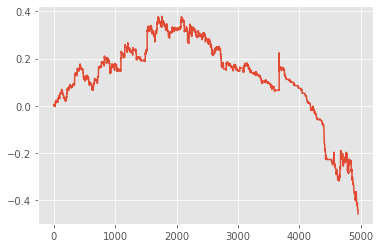

AttributeError: ignored

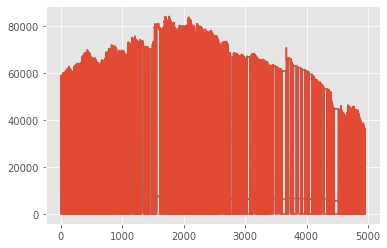

In [ ]:
import numpy as np

plt.plot(range(len(rewards)), np.array(rewards).cumsum())
plt.show()

# Net worth plot

d = env.action_scheme.portfolio.performance

# lists = sorted(d.items()) # sorted by key, return+ a list of tuples
keys = d[0].keys()
x = range(len(d))
c = {}

for i in range(len(d)):
    for key in keys:
        if key != 'net_worth' and key != 'base_symbol':
            if not key in c:
                c[key] = []
            c[key].append(d[i][key])

for key in keys:
    if key != 'net_worth' and key != 'base_symbol':
        plt.plot(x, c[key], label=key)

plt.set_title("Net Worth")

plt.show()